- **Autor:** Jeremy Comino Raigón
- **Curso:** Q1 2023-2024
- **Profesor:** Javier Béjar

# Problema 4: Se Discreto

Primeramente vamos a establecer el entorno de trabajo.

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)


from scipy.stats import normaltest

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from scipy import stats 
from sklearn.preprocessing import PowerTransformer

A continuación haremos la carga de datos:

In [9]:
df = pd.read_csv("appendicitis.tsv", sep= '\t')
df.head(5)
df.shape
df["target"].value_counts()

,At1,At2,At3,At4,At5,At6,At7,target
0,0.213,0.554,0.207,0.000,0.000,0.749,0.220,1
1,0.458,0.714,0.468,0.111,0.102,0.741,0.436,1
2,0.102,0.518,0.111,0.056,0.022,0.506,0.086,1
3,0.187,0.196,0.105,0.056,0.029,0.133,0.085,1
4,0.236,0.804,0.289,0.111,0.066,0.756,0.241,1


(106, 8)

target
0    85
1    21
Name: count, dtype: int64

Podemos ver un dataset de 106 muestras y que contiene 7 atributos más la variable objetivo. Donde predomina los valores donde 0 (la persona no sufre apendicitis) frente a los valores 1 (la persona sufre apendicitis).

A continuación, haremos la separación del conjunto de datos según lo especificado en el apartado a del problema.


In [10]:
Target = df["target"]

In [11]:
df_train, df_test= train_test_split(df, test_size=0.40, random_state=10, stratify=Target)

df_train.head(5)

,At1,At2,At3,At4,At5,At6,At7,target
105,0.462,0.911,0.551,0.167,0.154,0.931,0.500,0
92,0.471,0.679,0.466,0.208,0.196,0.556,0.388,0
80,0.431,0.839,0.491,0.333,0.293,0.874,0.452,0
100,0.778,0.732,0.769,0.722,1.000,0.503,0.608,0
38,0.320,0.946,0.415,0.208,0.150,0.765,0.319,0


## Preprocesado de datos

A continuación haremos el preprocesado de estos datos. Para hacer este preprocesado primero lo haremos al conjunto de datos de train y seguidamente le aplicaremos el mismo preproceso al conjunto de test.

### Visualización univariable

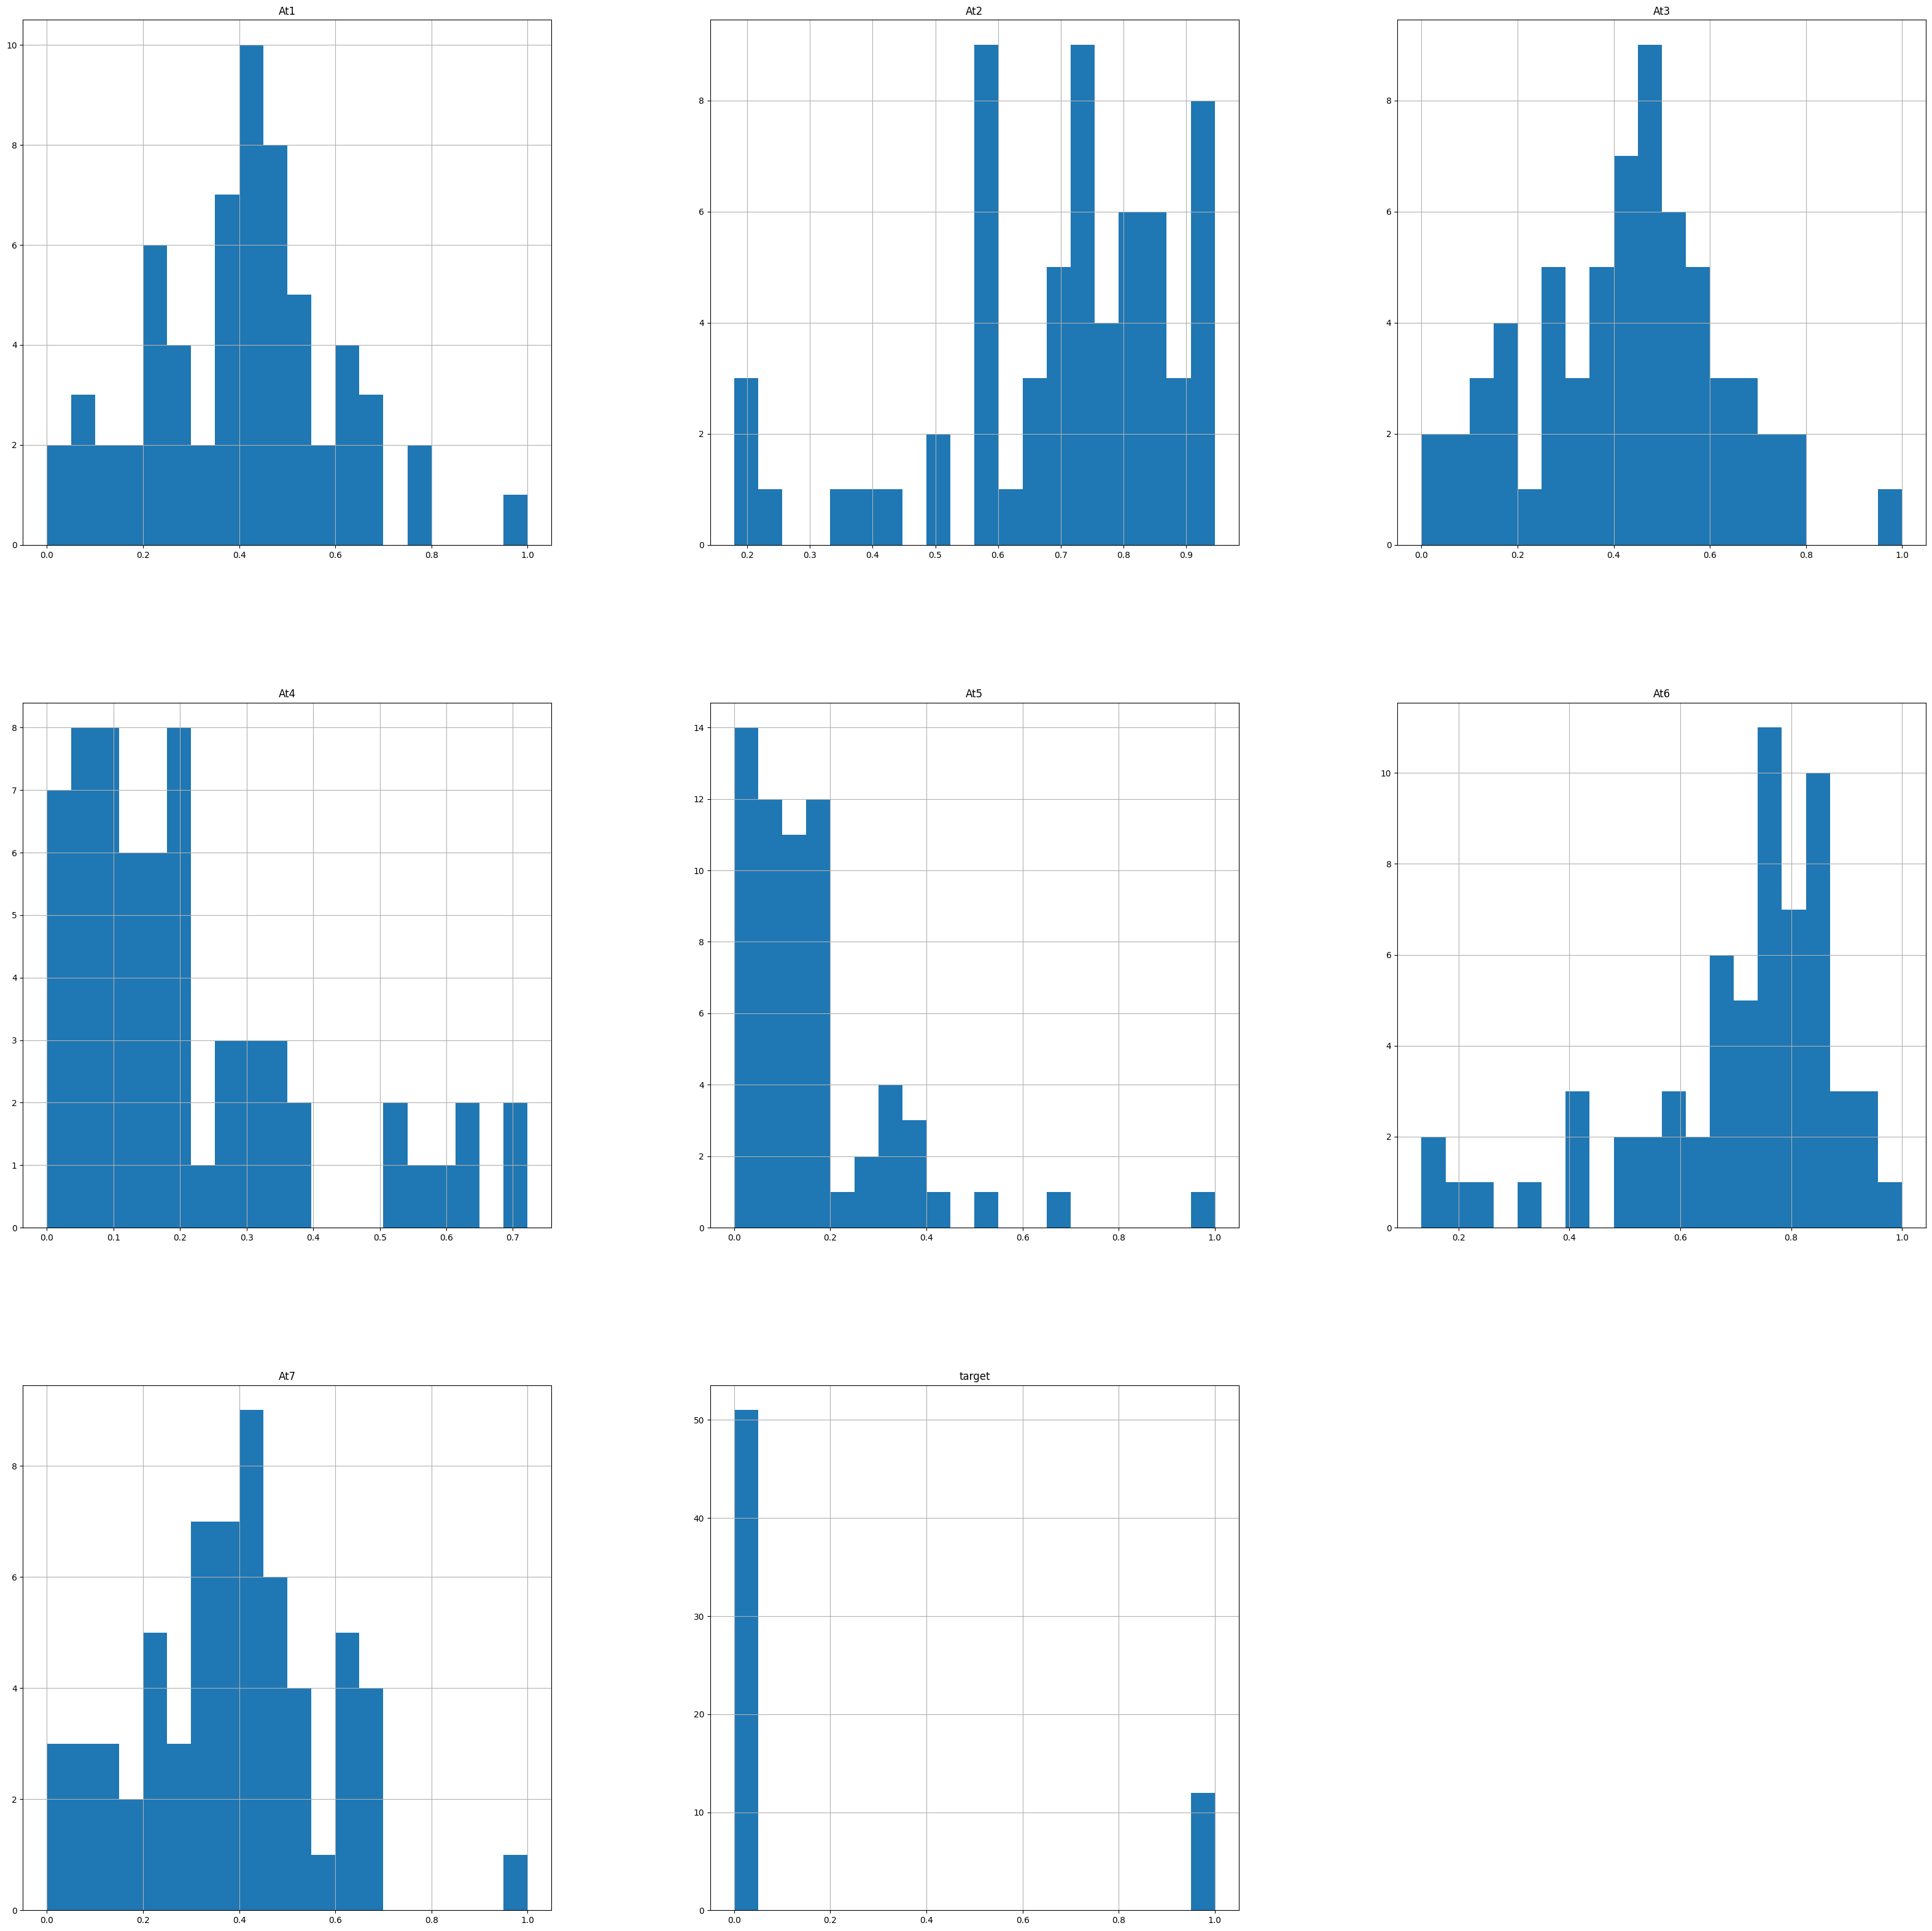

In [12]:
_=df_train.hist(bins=20, figsize=(40,40))

Podemos observar que la gran mayoría de atributos del conjunto de datos no siguen una distribución normal. Concretamente, *At1* *At3* y *At7* podemos ver a primeras que pueden seguir una distribución normal. A su vez, *At4* y*At5* siguen una distribución exponencial. Para estar más seguros, haremos un test de normalidad a continuación.

In [13]:
tanto_por_1_confianza = 0.95
p_v = 1-tanto_por_1_confianza
columns = list(df_train.columns)
for column in columns:
    res = normaltest(df_train[column], nan_policy = "omit")
    # si e p_value es menor al p_v significa que rechazamos la hipotesi nula y por lo tanto no sigue una distribución gaussiana
    if(res.pvalue <= p_v):
        print(column + " no tiene una distribución normal")
    else:
        print(column + " tiene una distribución normal")

At1 tiene una distribución normal
At2 no tiene una distribución normal
At3 tiene una distribución normal
At4 no tiene una distribución normal
At5 no tiene una distribución normal
At6 no tiene una distribución normal
At7 tiene una distribución normal
target no tiene una distribución normal


Nuestras suposiciones eran ciertas y por lo tanto haremos el preprocesado acorde a estos datos. 

### Visualización bivariable
A continuación haremos la visualización bivariable. Con el objetivo de eliminar posibles atributos altamente correlacionados.

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

<Axes: >

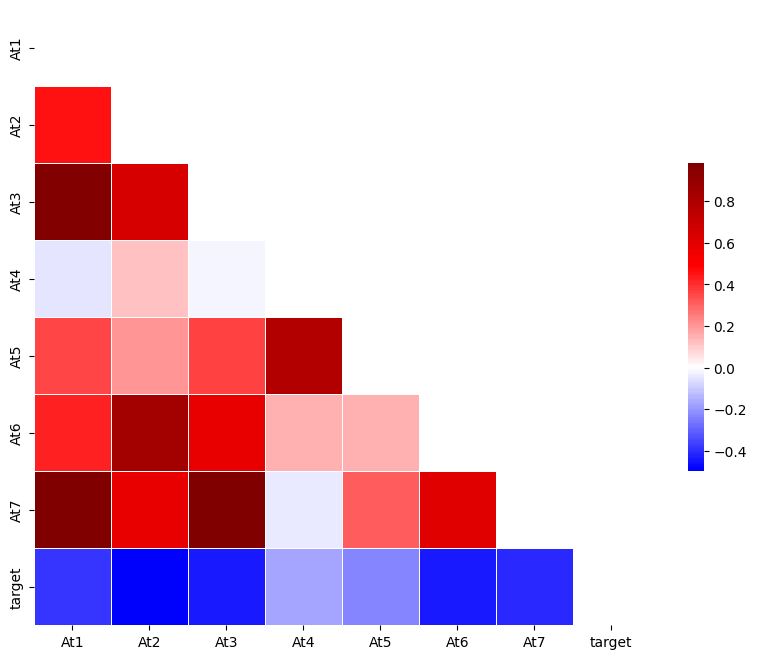

In [14]:
correlaciones = df_train.corr()
mask = np.triu(np.ones_like(correlaciones,dtype = bool))
plt.subplots(figsize=(10,8))
sns.heatmap(correlaciones, mask = mask, cmap="seismic",center = 0, square=True,linewidths=.5, cbar_kws={"shrink": .5})

Podemos observar que la variable objetivo no llega a tener una alta correlación con el resto de atributos (la correlación está entorno al **[0 - -0.4]**). Lo que podemos destacar los siguientes hechos:
- Las variables *At1*, *At3* y *At7* (variables que tienen una distribución normal) están altamente correlacionadas de forma positiva (entorno al **0.9**).
- Las variables *At2* y *At6* están altamente correlacionadas de forma positiva.
- Las variables *At4* y *At5* llegan a estar altamente correlacionadas de forma positiva.

Viendo estos hechos y viendo las distribuciones individuales. Eliminaremos 2 de las variables de distribución gaussiana debido a que en sus histogramas hay una gran similitud. En cambio el resto lo preservaremos debido a que a pesar de que están altamente correlacionadas, sus histogramas presentas diferencias notorias en ciertas partes de estos.

In [15]:
cols_to_eliminate = ["At3","At7"]
df_train.drop(cols_to_eliminate, axis= 1, inplace= True)
df_test.drop(cols_to_eliminate, axis= 1, inplace= True)


### Valores perdidos
A continuación veremos si las variables llegan a tener valores perdidos tanto en el conjunto de entrenamiento como el de test.

In [16]:
df_train.isna().sum()

At1       0
At2       0
At4       0
At5       0
At6       0
target    0
dtype: int64

In [17]:
df_test.isna().sum()

At1       0
At2       0
At4       0
At5       0
At6       0
target    0
dtype: int64

Podemos ver que tanto el conjunto de entrenamiento como el conjunto de test no presentan valores perdidos. Por lo tanto, ahora pasaremos al tratamiento de valores extremos

### Tratamiento de valores extremos

Para este apartado tenemos principalmente dos inconvenientes. El primero es la no normalidad de los datos, haciendo que tengamos que recurrir a otro tipo de métodos diferentes a la utilización de media y la desviación típica. El segundo es el número de muestras. Nuestro conjunto de datos consta únicamente de 106 filas haciendo que la eliminación de pocas filas pueda suponer un gran cambio a nuestro resultado final debido a la importancia de estos valores extremos. 

Primeramente vamos a ver si las variables de manera visual llegan a presentar valores extremos.

<Axes: >

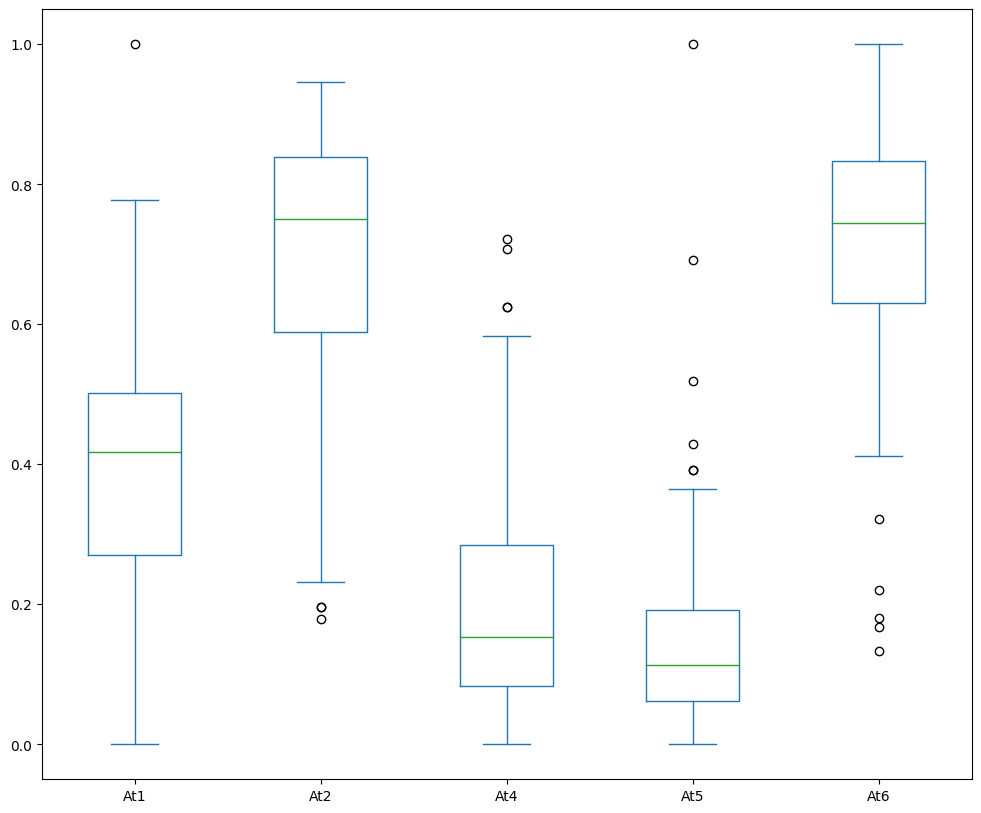

In [18]:
df_train.iloc[:,:-1].plot.box(figsize=(12,10))

<Axes: >

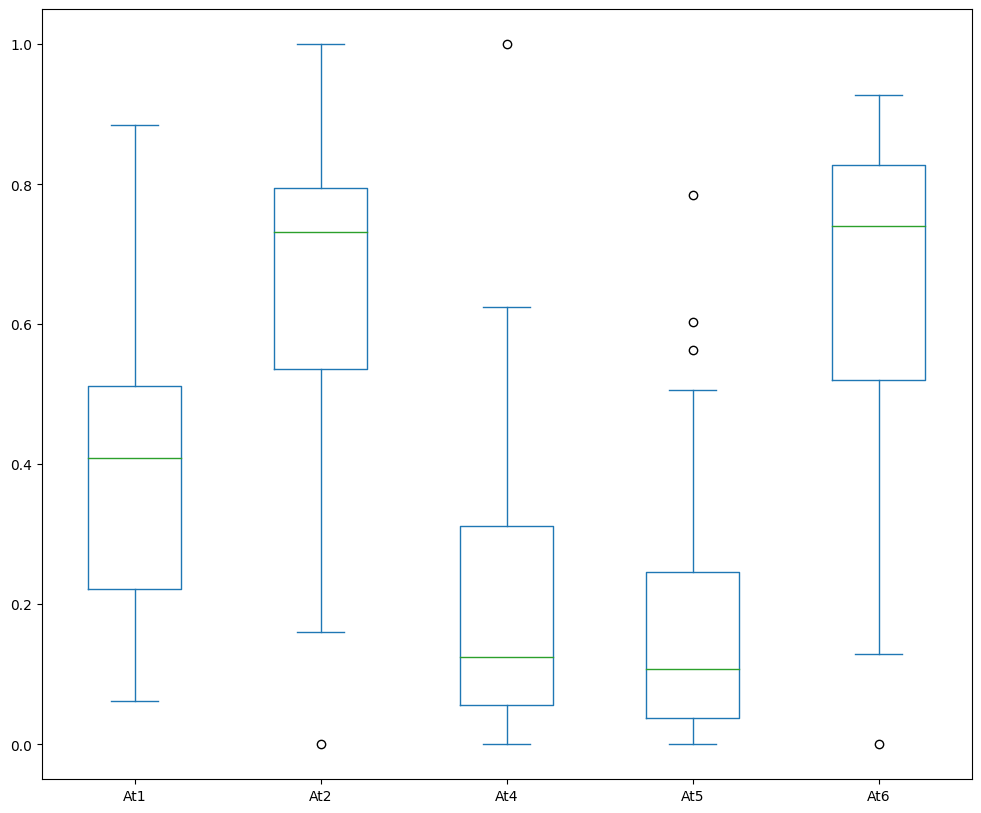

In [19]:
df_test.iloc[:,:-1].plot.box(figsize=(12,10))

Podemos ver que llegan a presentar valores extremos pero no llegan a ser significativo respecto al total de datos (suponen el 5% aproximadamente en el peor caso). A continuación, haremos la preparación de los modulos para hacer este proceso de eliminación de datos extremos.

In [20]:
from sklearn.neighbors import LocalOutlierFactor

Ahora haremos un estudio en función de el número de vecinos. Primeramente utilizaremos el algoritmo donde se compara con el 20% de los datos aproximadamente.

In [21]:
rows = df_train.shape[0]
percentage = 0.1
local_outlier_factor = LocalOutlierFactor(n_neighbors=int(percentage* rows))
result = local_outlier_factor.fit_predict(df_train.iloc[:,:-1].values)
outliers = result == -1
no_outliers = result == 1
num_outliers = df_train.loc[outliers,:].shape[0]
print("Numero de outliers:", num_outliers)
print("El porcentaje eliminado es:", num_outliers/rows*100)



Numero de outliers: 7
El porcentaje eliminado es: 11.11111111111111


Podemos ver que el algoritmo a considerado 7 instancias como extremas. Lo que supone un 11% del conjunto de datos de entrenamiento.
A continuación, repetiremos el experimento aumentando esta vez el porcentaje de vecinos que utiliza *LocalOutlierFactor*.

In [22]:

percentage = 0.3
local_outlier_factor = LocalOutlierFactor(n_neighbors=int(percentage* rows))
result = local_outlier_factor.fit_predict(df_train.iloc[:,:-1].values)
outliers = result == -1
no_outliers = result == 1
num_outliers = df_train.loc[outliers,:].shape[0]
print("Numero de outliers:", num_outliers)
print("El porcentaje eliminado es:", num_outliers/rows*100)

Numero de outliers: 13
El porcentaje eliminado es: 20.634920634920633


Podemos ver que aumentando el porcentaje hasta un 30% hace que aumenten el número de outliers, pero esto a su vez nos hace que lleguemos a eliminar un 20% del conjunto de entrenamiento. Haciendo que podamos perder bastante información. Por lo tanto, solo utilizaremos el primer resultado para hacer la eliminación de valores extremos.

In [23]:
percentage = 0.1
local_outlier_factor = LocalOutlierFactor(n_neighbors=int(percentage* rows))
result = local_outlier_factor.fit_predict(df_train.iloc[:,:-1].values)
no_outliers = result == 1
df_train = df_train.loc[no_outliers,:]
df_train.shape

(56, 6)

In [24]:
result = local_outlier_factor.fit_predict(df_test.iloc[:,:-1].values)
no_outliers = result == 1
df_test = df_test.loc[no_outliers,:]
df_test.shape

(38, 6)

### Normalización
Para este proceso haremos 2 tratamientos. Sabemos que *At1* es normal, por lo tanto, un estandarizado. En cambio para el resto utilizaremos transformaciones exponenciales como Box-Cox y Yeo-Johnson.

In [25]:
std = df_train["At1"].std()
mean = df_train["At1"].mean()

df_train["At1"] = (df_train["At1"] -mean)/std
df_test["At1"] = (df_test["At1"] -mean)/std

print("Media de training: ", df_train["At1"].mean())
print("Desviación típica de training: ", df_train["At1"].std())
print("Media de test: ", df_test["At1"].mean())
print("Desviación típica de test: ", df_test["At1"].std())

Media de training:  -1.9032394707859825e-16
Desviación típica de training:  1.0
Media de test:  -0.053002882810045365
Desviación típica de test:  0.9930837698832599


A continuación haremos la transformación del resto de variables, para esto primero comprobaremos un requisito del Box-Cox para saber si podemos utilizar esta transformación.

In [26]:
from sklearn.preprocessing import PowerTransformer
non_normal_attributes  = df_train.iloc[:,1:-1]
non_normal_attributes_test = df_test.iloc[:,1:-1]
#comprobamos si algún valor es menor a 0
(non_normal_attributes < 0).values.any()
#comprobamos si algún valor es igual a 0
(non_normal_attributes == 0).values.any()
#comprobamos si algún valor es menor a 0
(non_normal_attributes_test < 0).values.any()
#comprobamos si algún valor es igual a 0
(non_normal_attributes_test == 0).values.any()


False

True

False

True

Podemos ver que los atributos no tienen valores negativos pero si valores 0. Por lo tanto, a la hora de hacer la transformación Box-Cox añadiremos un epsilon a estos valores para que funcione la transformación.

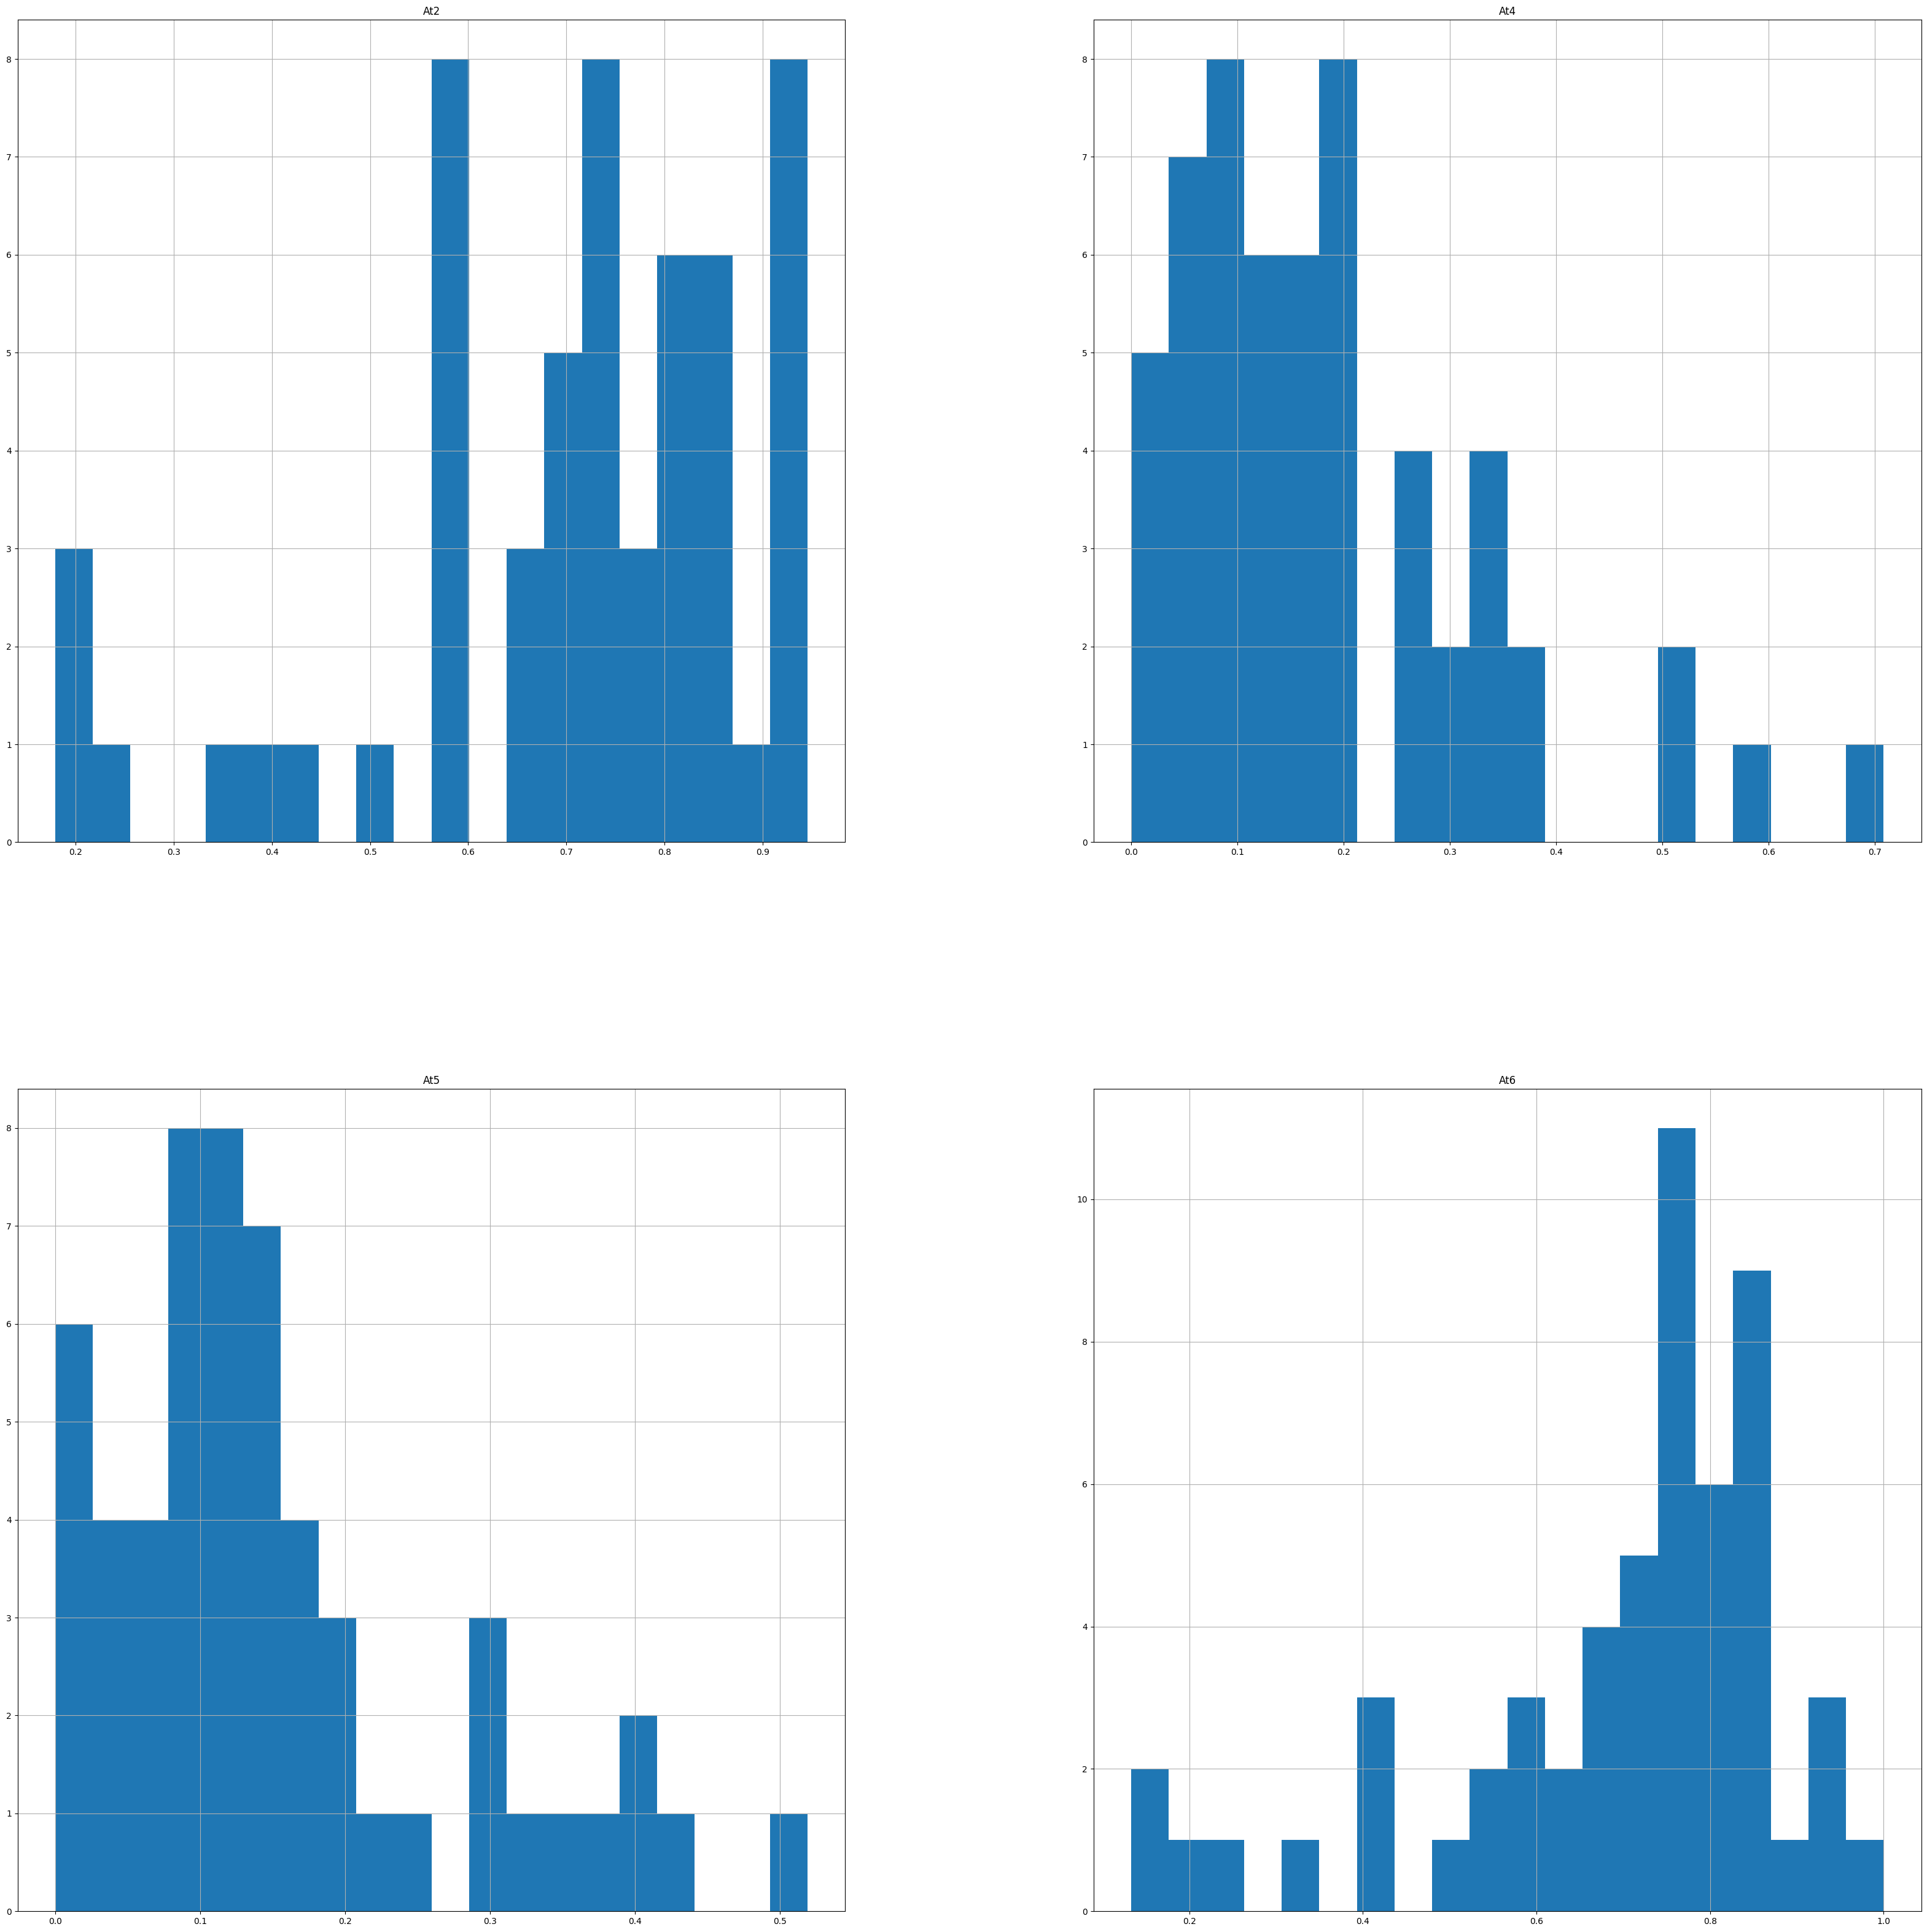

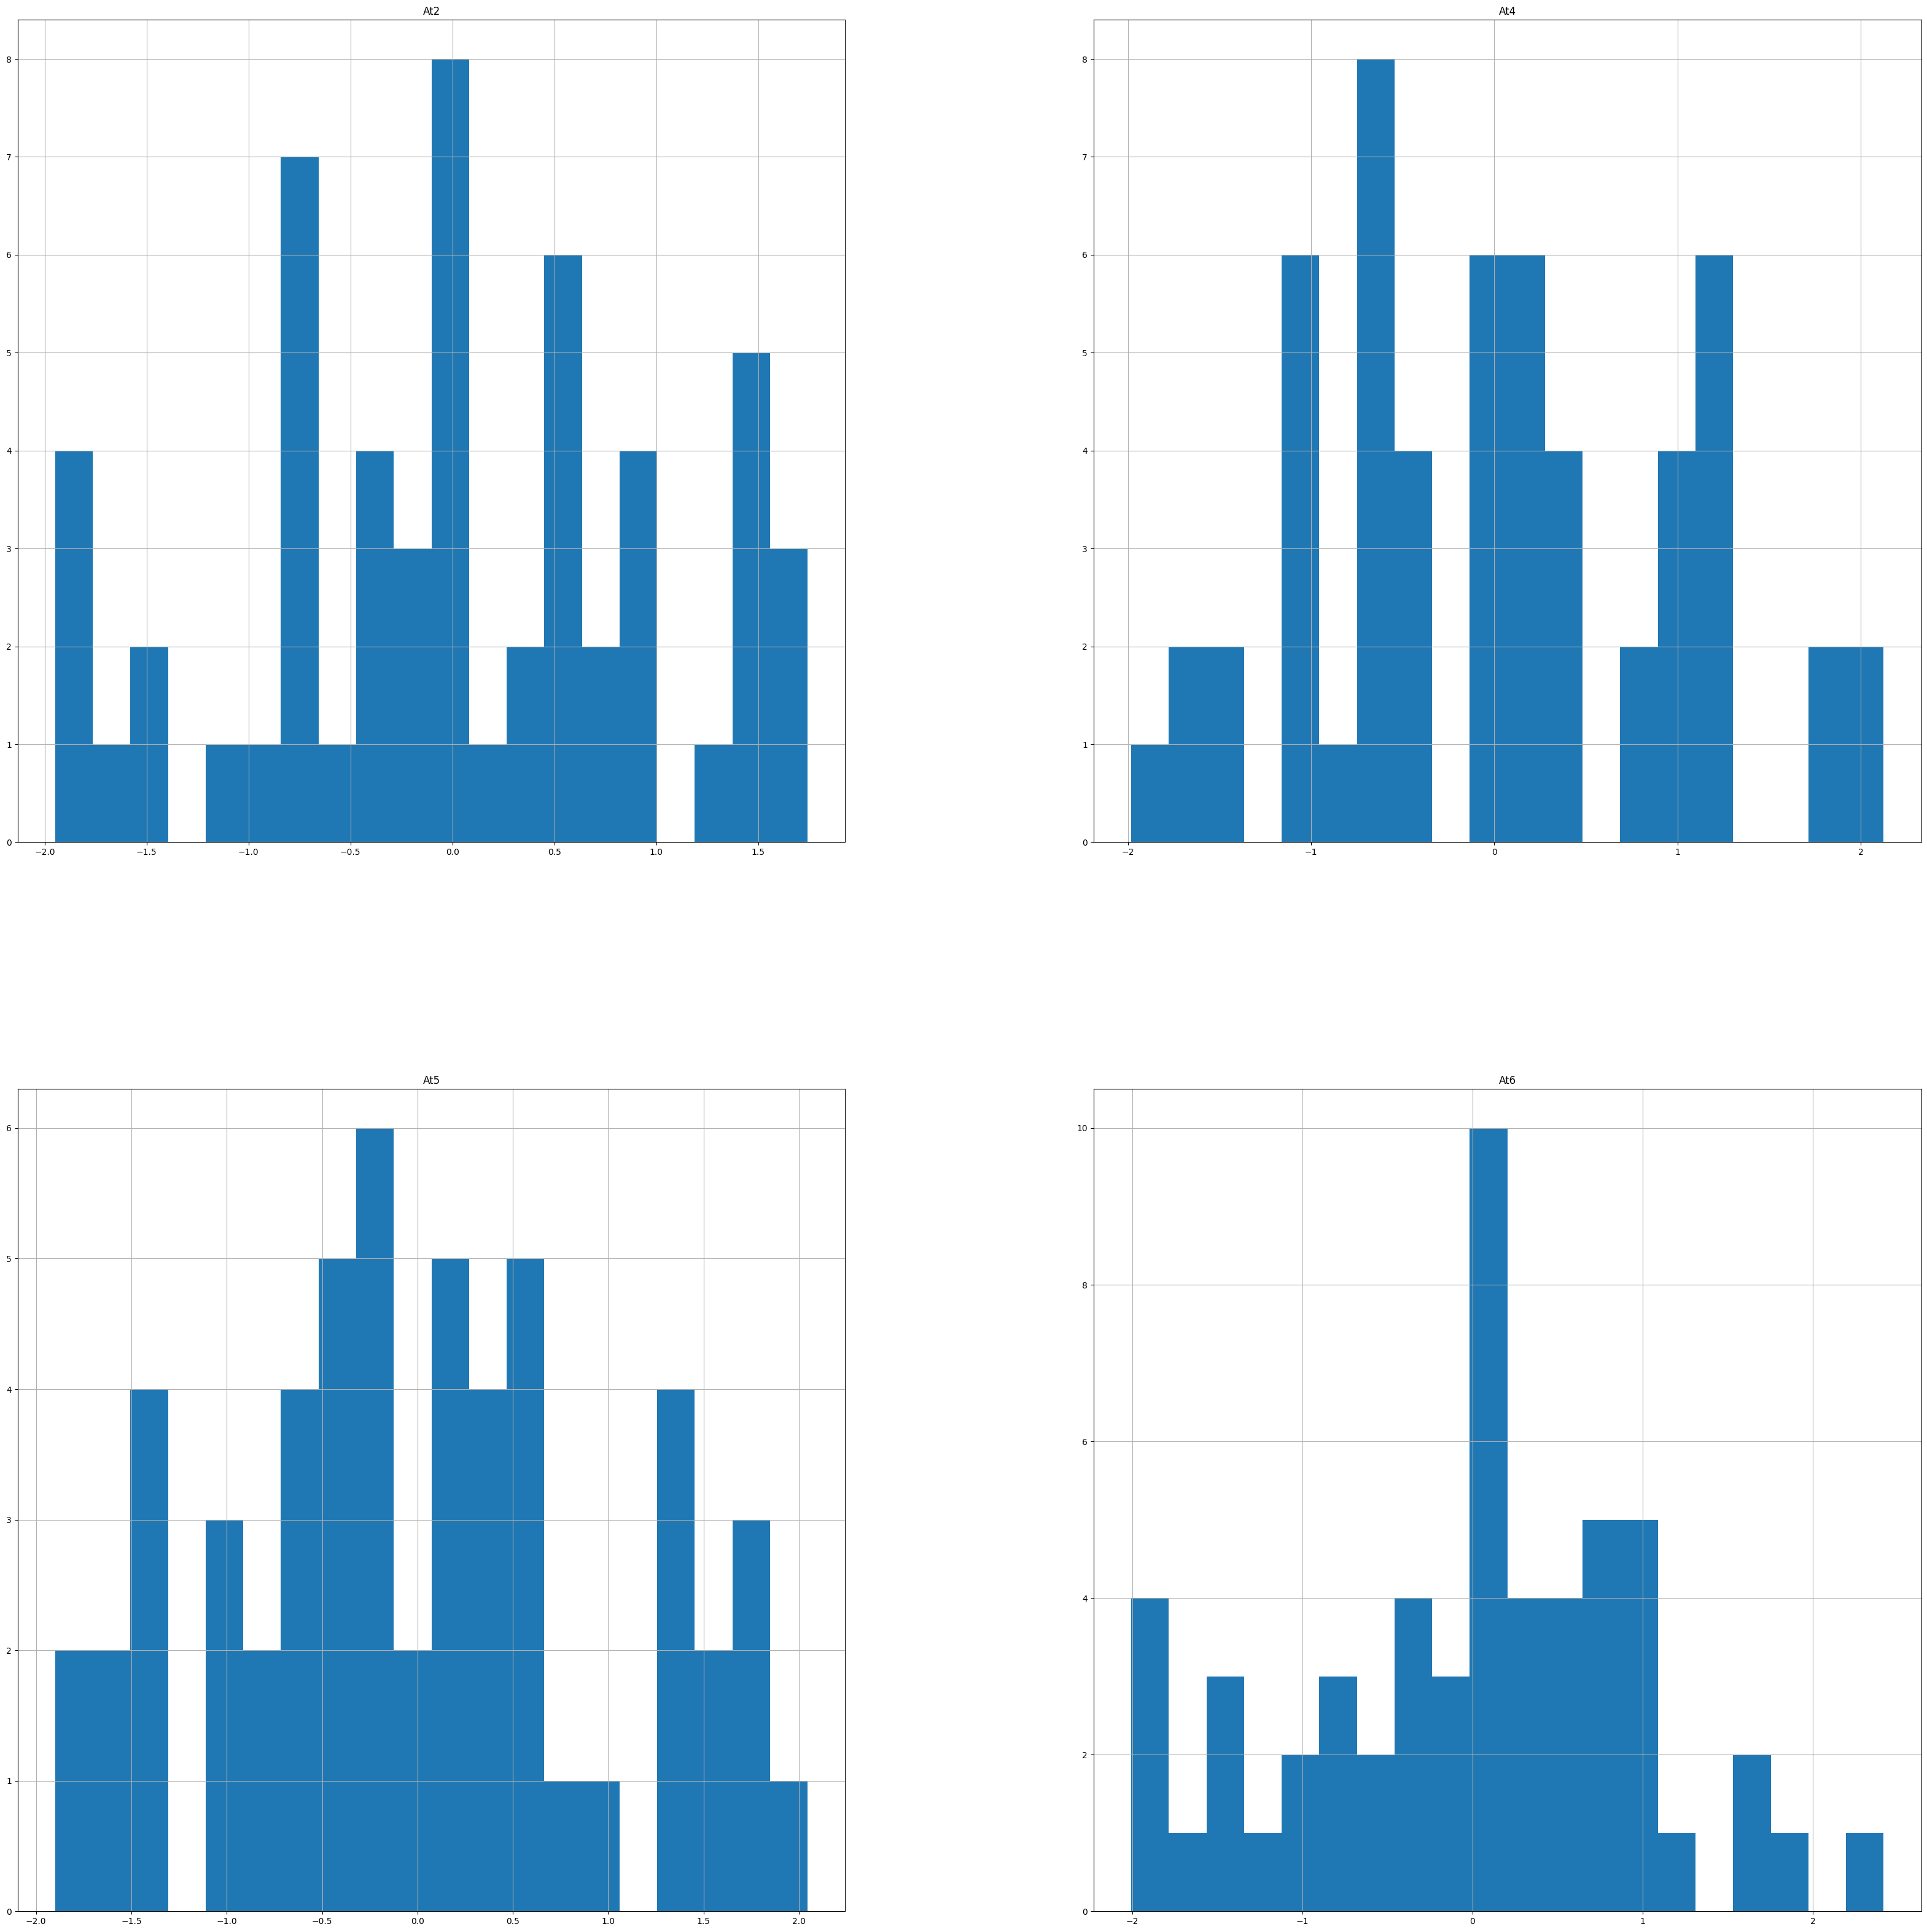

In [27]:
yj_power = PowerTransformer(method='yeo-johnson')
yeo_jhonson_transform = non_normal_attributes.copy()

_=yeo_jhonson_transform.hist(bins=20, figsize=(40,40))
yeo_jhonson_transform.loc[:,:] = yj_power.fit_transform(yeo_jhonson_transform.loc[:,:])
_=yeo_jhonson_transform.hist(bins=20, figsize=(40,40))

Podemos ver que la transformación ha afectado principalmente a las variables con una distribución exponencial. Intentandolas hacer más gaussianas.

A continuación haremos la transformación Box-Cox

In [28]:
epsilon = 0.0001
box_cox_transform = non_normal_attributes.copy()
box_cox_transform.replace(to_replace=0, value= epsilon, inplace= True)


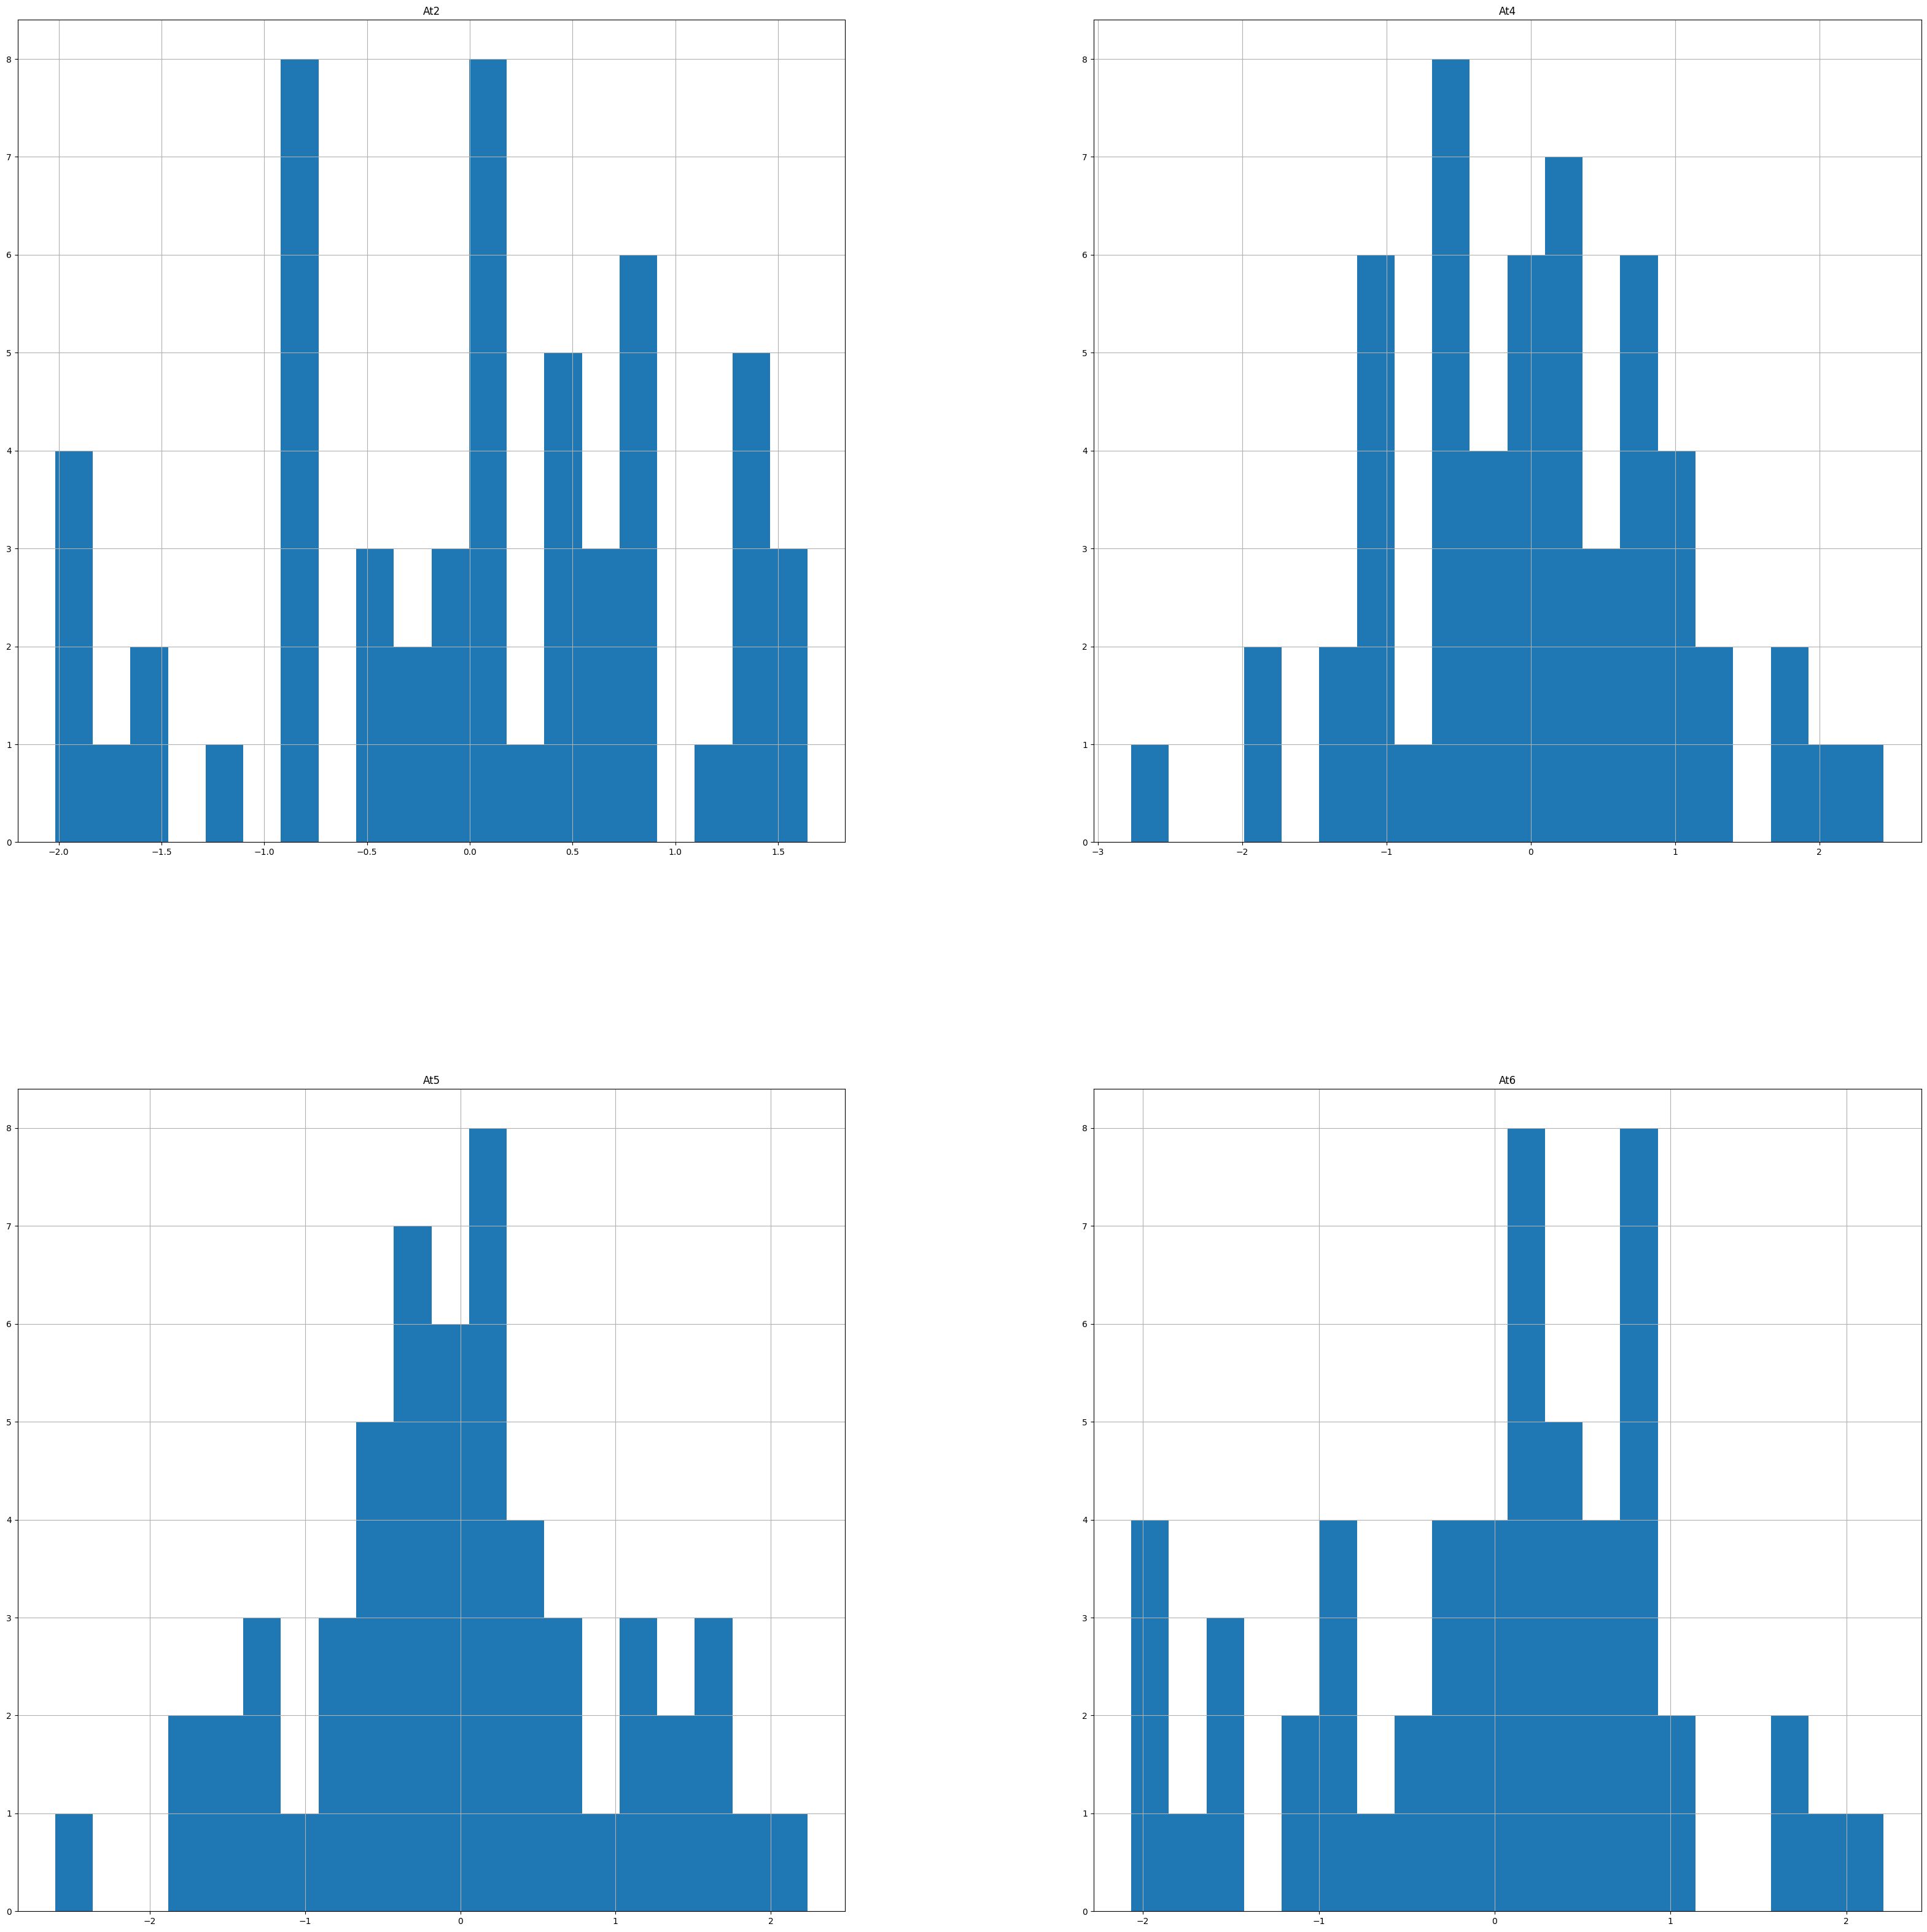

In [29]:
box_cox_power = PowerTransformer(method='box-cox')
box_cox_transform.loc[:,:] = box_cox_power.fit_transform(box_cox_transform.loc[:,:])
_=box_cox_transform.hist(bins=20, figsize=(40,40))

Vemos que la transformación box-cox llega a tranformar de mejor manera todas las variables, haciendo que lleguen a parecerse a una distrbución normal. Por esta razón utilizaremos esta transformación para conjunto de training y test.

In [30]:
df_train.iloc[:,1:-1] = box_cox_transform
box_cox_transform = non_normal_attributes_test.copy()
box_cox_transform.replace(to_replace=0, value= epsilon, inplace= True)
box_cox_transform.loc[:,:] = box_cox_power.fit_transform(box_cox_transform.loc[:,:])
df_test.iloc[:,1:-1] = box_cox_transform

### Naive Bayes

A continuación, haremos la prueba de Naive Bayes. Primero de todo, estableceremos el entorno.

In [31]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

Como hemos conseguido que nuestros atributos lleguen a tener una distribución normal de los datos. Utilizaremos Naive Bayes del tipo Gaussiano. Ya que se adecua nuestras necesidades.

In [32]:
X_train = df_train.iloc[:,:-1]
Y_train = df_train["target"]
X_test = df_test.iloc[:,:-1]
Y_test = df_test["target"]

In [33]:
gnb = GaussianNB()
r2 = np.mean(cross_val_score(gnb,X_train,Y_train,cv=10))
print("Acierto medio:",r2)

Acierto medio: 0.8833333333333334


In [34]:
gnb_model =  GaussianNB().fit(X_train,Y_train)
prediction =gnb_model.predict(X_test)
Accuracy_NB = accuracy_score(Y_test, prediction)
print("Acierto del Naive Bayes aplicado al conjunto de test:", Accuracy_NB)

Acierto del Naive Bayes aplicado al conjunto de test: 0.8421052631578947


Podemos ver que aplicando Naive Bayes sobre el conjunto de test hace que el acierto medio sea 0.84 (4 centésimas menos comparado con la validación cruzada). Haciendo que igualmente sea una acierto relativamente bueno.

In [35]:
print("Informe de Clasificación")
print(classification_report(prediction, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación
                 precision    recall  f1-score   support

No_Appendicitis       0.90      0.90      0.90        29
   Appendicitis       0.67      0.67      0.67         9

       accuracy                           0.84        38
      macro avg       0.78      0.78      0.78        38
   weighted avg       0.84      0.84      0.84        38



Podemos ver que a pesar de que tiene un acierto medio cercano al 0.85 en el conjunto de test. Cuando predecimos con el conjunto de test este le cuesta predecir los casos positivos de apendicitis. Esto puede ser debido al gran desbalance en la muestra (de las 106 instancias iniciales, únicamente 21 tenían un target de 1).

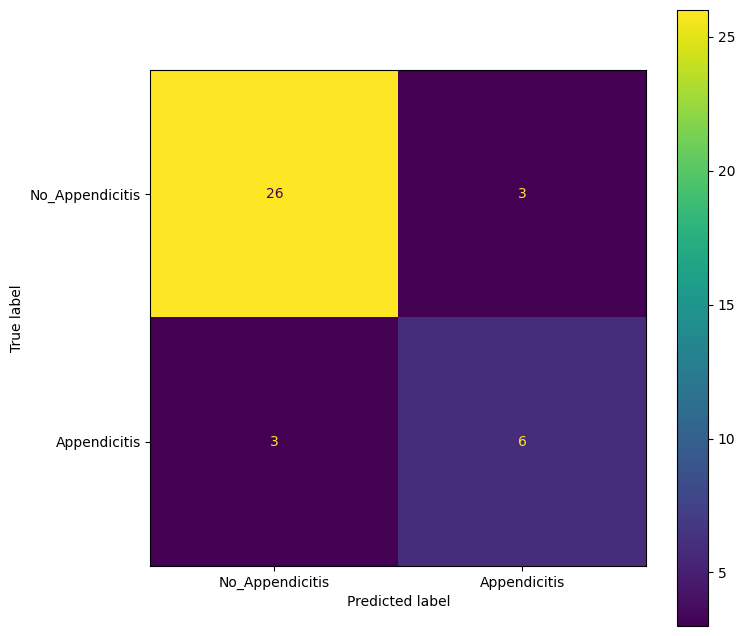

In [36]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

Lo que podemos destacar que el número de la gente que tiene apendicitis y se ha predicho que no es el mismo que de gente que no tiene pero se ha predicho que tenía. A su vez, aunque parezca que hay pocos valores mal predichos. Tenemos que tener en cuenta el volumen de test. Con este volumen del conjunto de test, hemos predicho mal cerca del 16% del total. Cifra que no deja de ser grande.

### Regresión Logística
A continuación haremos el estudio de los parametros. Para esto, queremos ver que tanto el tipo de penalización y Coste. Por lo tanto utilizaremos el solver liblinear que llega a ofrecer soporto a los 2 tipos de penalización que hay.

In [37]:
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [38]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, Y_train);

In [39]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.917,1
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.900,2
13,"{'C': 0.0630957344480193, 'penalty': 'l2'}",0.900,2
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.897,4
1,"{'C': 0.001, 'penalty': 'l2'}",0.883,5


Podemos ver que el mejor acierto lo tenemos cuando utilizamos la regresión logística con la penalización l2 y una C de 0.25 aproximadamente.

In [40]:
prediction =lr_gs.predict(X_test)
Accuracy_LR = accuracy_score(Y_test, prediction)
print("Acierto de la regresión logística aplicado al conjunto de test:", Accuracy_LR)

Acierto de la regresión logística aplicado al conjunto de test: 0.868421052631579


Podemos ver que el acierto de la regresión logística esta cerca del 0.87 siendo un valor superior al conseguido con naive bayes.

In [41]:
print("Informe de Clasificación")
print(classification_report(prediction, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.88      0.92        32
   Appendicitis       0.56      0.83      0.67         6

       accuracy                           0.87        38
      macro avg       0.76      0.85      0.79        38
   weighted avg       0.90      0.87      0.88        38



A pesar de tener un mayor acierto. Perdemos precisión en los aciertos de apendicitis. Teniendo una precisión 11 centésimas menos respecto a naive bayes.

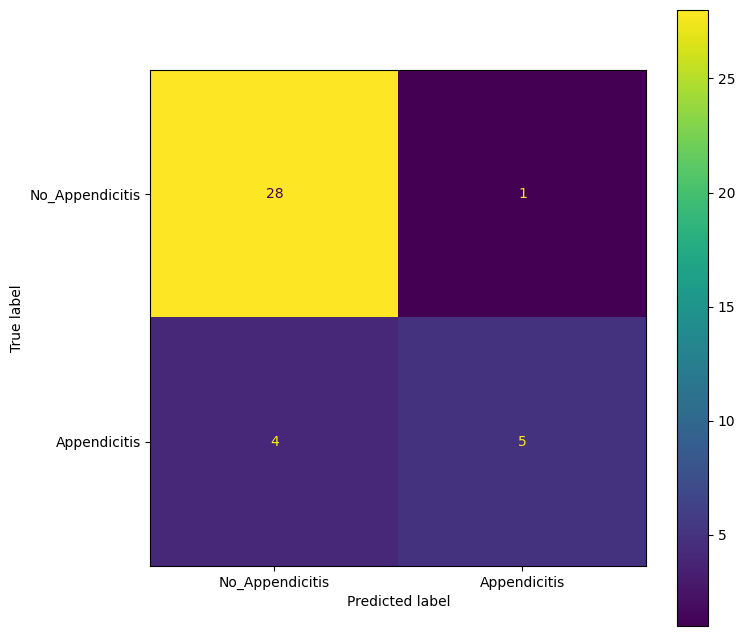

In [42]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

Podemos ver que respecto a naive Bayes. El numero de gente que no tiene apendicitis y que se ha predicho correctamente ha aumentado. A su vez y relacionando con el informe de clasificación. El numero de gente con apendicitis y ha sido predicho de manera erronea ha aumentado. 

Por último quiero resaltar que en este caso, el porcentaje de malas prediciones es igual respecto a naive bayes (aproximadamente un 16%). Por lo tanto no sería mejor modelo si lo comparamos con naive Bayes y el hecho de que el peor caso (decir a una persona con apendicits que no lo tiene) ha aumentado.

### K-vecinos más cercano
A continuación haremos el mismo experimento utilizando el algoritmo de k-vecinos más cercanos. Primeramente estableceremos el entorno.


In [43]:
from sklearn.neighbors import KNeighborsClassifier


Como los principales hiperparametros es el número de neighbors y el tipo el tipo de pesos que se le asigna a cada componente. Haremos una busqueda en rejilla para encontrar los mejores hiperparametros

In [44]:
param ={'n_neighbors':[1,5,10,20,30,40,50], 
        'weights':['uniform','distance'],
        'leaf_size':[1, 5, 10, 20, 30],
        'metric': ['l2', 'l1', 'cosine']}

k_neighbors = KNeighborsClassifier()
k_neighbors_gr = GridSearchCV(k_neighbors,param,cv=10, n_jobs=-1, refit=True)
k_neighbors_gr.fit(X_train,Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

In [45]:
show_html(pd.DataFrame(k_neighbors_gr.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
47,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 10, 'weights': 'distance'}",0.91,1
61,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.91,1
187,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}",0.91,1
5,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 10, 'weights': 'distance'}",0.91,1
89,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 10, 'weights': 'distance'}",0.91,1


Podemos ver que teniendo mirando los 10 vecinos más cercanos y utilizando como peso la metrica de distancia. Llegamos a tener un acierto del 91% mirando el conjunto de entrenamiento. Ahora lo haremos sobre el conjunto de test

In [46]:
prediction =k_neighbors_gr.predict(X_test)
Accuracy_KN = accuracy_score(Y_test, prediction)
print("Acierto de K-Vecinos aplicado al conjunto de test:", Accuracy_KN)

Acierto de K-Vecinos aplicado al conjunto de test: 0.8157894736842105


A pesar de tener un gran acierto sobre el conjunto de entrenamiento.Vemos que su acierto baja un 10% aproximadamente con el conjunto de test.

In [47]:
print("Informe de Clasificación")
print(classification_report(prediction, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.82      0.89        34
   Appendicitis       0.33      0.75      0.46         4

       accuracy                           0.82        38
      macro avg       0.65      0.79      0.68        38
   weighted avg       0.90      0.82      0.84        38



Podemos observar en el informa de clasificación que aunque es el metodo que mejor predice los casos con no apendicitis. También es el peor prediciendo el caso contrario. Haciendo que no sea el más fiable en cuanto al proposito general.

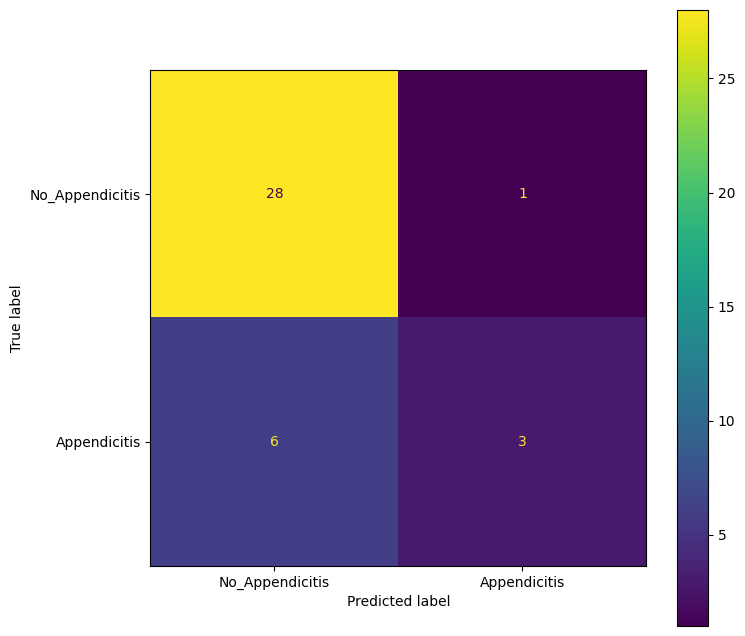

In [48]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(k_neighbors_gr, X_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

En la matriz de confusión vemos que los casos de apendicitis bien predichos se han movido hacia el sector de su izquierda respecto al resto de métodos utilizados.
A su vez, vemos que el porcentaje instancias mal predichas ha aumentado respecto al resto de métodos. Siendo ahora un un 18% aproximadamente (una diferencia no substancial pero que no deja de ser importante).

### KBinsDiscretizer
En este punto haremos uso de la función KBinsDiscretizer para poder discretizar todos nuestros atributos. Primeramente estableceremos el entorno y crearemos una función para poder hacer el proceso mejor.

In [49]:
from sklearn.preprocessing import KBinsDiscretizer

In [50]:
def getDiscretizer(table , strategy):
    encode2 = KBinsDiscretizer(n_bins=2,encode="onehot-dense",strategy=strategy, random_state=70)
    encode3 = KBinsDiscretizer(n_bins=3,encode="onehot-dense",strategy=strategy, random_state=70)
    encode4 = KBinsDiscretizer(n_bins=4,encode="onehot-dense",strategy=strategy, random_state=70)
    table2 = encode2.fit_transform(table)
    table3 = encode3.fit_transform(table)
    table4 = encode4.fit_transform(table)
    table2 = pd.DataFrame(table2)
    table3 = pd.DataFrame(table3)
    table4 = pd.DataFrame(table4)
    return table2, table3, table4

A continuación obtendremos los nuevos conjuntos de datos de cada tipo.

In [51]:
listXQTrain = getDiscretizer(X_train, "quantile")
listXQTest = getDiscretizer(X_test, "quantile")

listXQTrain =list(listXQTrain)
listXQTest =list(listXQTest)

listXKTrain = getDiscretizer(X_train, "kmeans")
listXKTest = getDiscretizer(X_test, "kmeans")

listXKTrain= list(listXKTrain)
listXKTest = list(listXKTest)


/home/jeremy/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/jeremy/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/jeremy/.local/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/jeremy/.local/lib/python3.8/site-packages/sklearn/pr


A continuación haremos todas las pruebas para saber que tipo de discretización es mejor. Este proceso lo haremos primero con los conjuntos de quantile, después kmeans y por último evaluaremos el total.

#### Método Quantile

In [52]:
from sklearn.naive_bayes import CategoricalNB

En este caso, al ser todas variables categoricas utilizaremos Naive Bayes del tipo categorico.

In [53]:
for i in range(0, len(listXQTrain)):
    x = listXQTrain[i]
    gnb = CategoricalNB()
    r2 = np.mean(cross_val_score(gnb,x,Y_train,cv=10))
    print(f"Acierto medio del conjunto con Quantile={i+2}:",r2)

Acierto medio del conjunto con Quantile=2: 0.8566666666666667
Acierto medio del conjunto con Quantile=3: 0.8633333333333335
Acierto medio del conjunto con Quantile=4: 0.8433333333333334


Podemos ver que a medida que discretizamos de mejor de manera más pequeña, la precisión irá disminuyendo. Aunque si lo comparamos con el conjunto sin hacer este preproceso, estos valores són inferiores pero no de manera notoria.

In [54]:
list_prediction =[]
for i in range(0, len(listXQTrain)):
    x = listXQTrain[i]
    xtest = listXQTest[i]
    gnb_model =  CategoricalNB().fit(x,Y_train)
    prediction =gnb_model.predict(xtest)
    list_prediction.append(prediction)
    Accuracy_NB = accuracy_score(Y_test, prediction)
    print(f"Acierto del Naive Bayes aplicado al conjunto de test con Quantile={i+2}:", Accuracy_NB)

Acierto del Naive Bayes aplicado al conjunto de test con Quantile=2: 0.7894736842105263
Acierto del Naive Bayes aplicado al conjunto de test con Quantile=3: 0.7631578947368421
Acierto del Naive Bayes aplicado al conjunto de test con Quantile=4: 0.8157894736842105


Podemos ver eso si, que el acierto sobre el conjunto de test, se mantiene centrado sobre un valor entre 0.76 y 0.82 aproximadamente. 

In [55]:
for i in range(0, len(list_prediction)):
    pred = list_prediction[i]
    print(f"Informe de Clasificación con Quantile={i+2}")
    print(classification_report(pred, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación con Quantile=2
                 precision    recall  f1-score   support

No_Appendicitis       0.76      0.96      0.85        23
   Appendicitis       0.89      0.53      0.67        15

       accuracy                           0.79        38
      macro avg       0.82      0.74      0.76        38
   weighted avg       0.81      0.79      0.78        38

Informe de Clasificación con Quantile=3
                 precision    recall  f1-score   support

No_Appendicitis       0.76      0.92      0.83        24
   Appendicitis       0.78      0.50      0.61        14

       accuracy                           0.76        38
      macro avg       0.77      0.71      0.72        38
   weighted avg       0.77      0.76      0.75        38

Informe de Clasificación con Quantile=4
                 precision    recall  f1-score   support

No_Appendicitis       0.83      0.92      0.87        26
   Appendicitis       0.78      0.58      0.67        12

       accuracy  

Vemos que a pesar de que con la discretización en 4 partes pueda dar un acierto mejor que el resto. Esta no llega a sacrificar su acierto en el grupo más importante, que es el grupo de personas que tienen apendicitis. En cambio, el resto de discretizaciones llegan a un gran acierto en el grupo de apendicitis en ambos casos. A continuación veremos sus respectivas matrices de confusión.

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

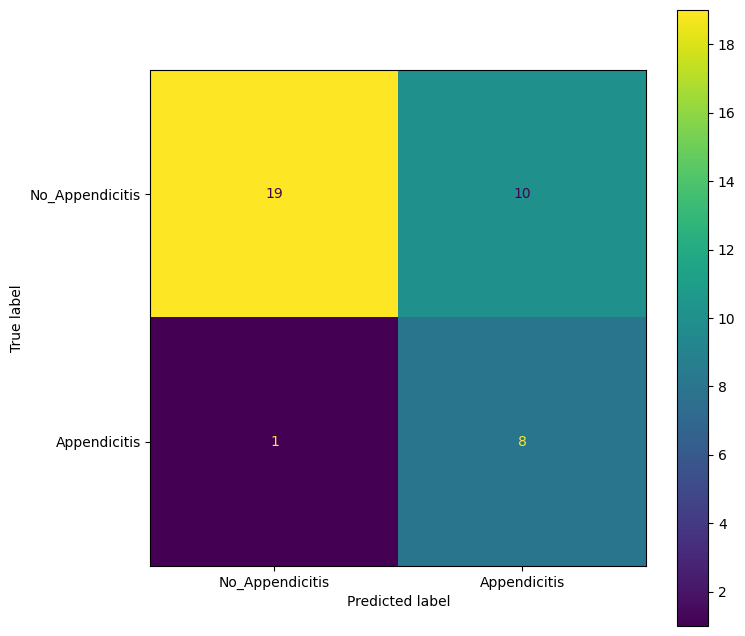

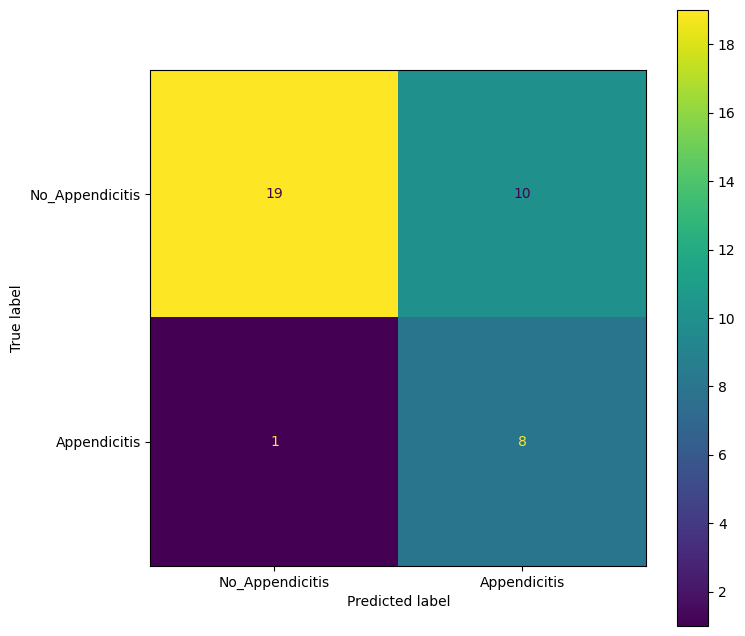

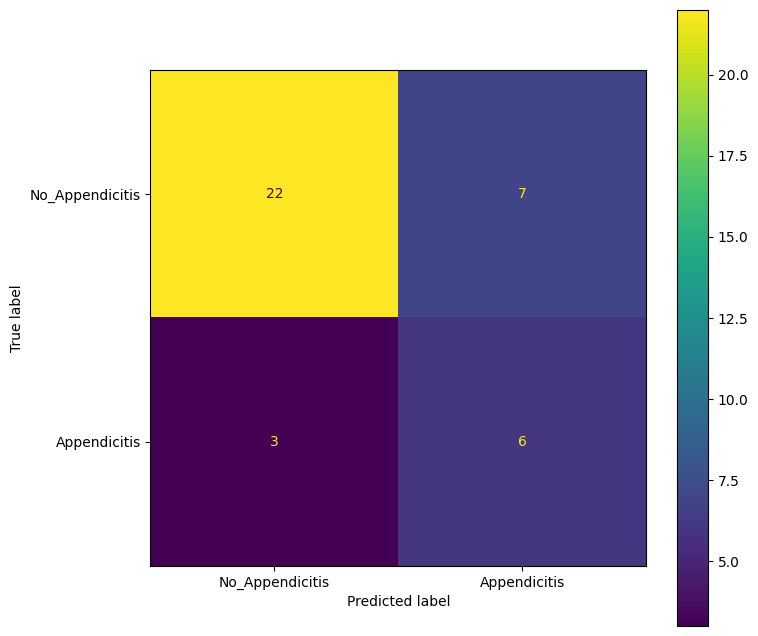

In [56]:
for i in range(0, len(listXQTrain)):
    x = listXQTrain[i]
    xtest = listXQTest[i]
    gnb_model =  GaussianNB().fit(x,Y_train)
    plt.figure(figsize=(8,8));
    _=ConfusionMatrixDisplay.from_estimator(gnb_model, xtest,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

Vemos que las matrices de confusión para las discretizaciones 2 y 3 son exactamente iguales y la matriz con 4 discretizaciones vemos lo que hemos explicado anteriormente. Hay más fallos en el caso de appendicits pero menos fallos en el caso contrario. A continuación haremos el proceso con la regresión logística.

In [57]:
list_lrgs =[]
for i in range(0, len(listXQTrain)):
    x = listXQTrain[i]
    lr = LogisticRegression(max_iter=10000, solver="liblinear")
    param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
    lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
    list_lrgs.append(lr_gs)
    lr_gs.fit(x, Y_train)


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

In [58]:
for i, lr in enumerate(list_lrgs):
    print(f"Mejores hiperparametros para Quantile={i+2}")
    show_html(pd.DataFrame(lr.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Mejores hiperparametros para Quantile=2


,params,mean_test_score,rank_test_score
30,"{'C': 31.622776601683793, 'penalty': 'l1'}",0.873,1
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.873,1
22,"{'C': 1.9952623149688788, 'penalty': 'l1'}",0.873,1
24,"{'C': 3.981071705534969, 'penalty': 'l1'}",0.873,1
26,"{'C': 7.943282347242813, 'penalty': 'l1'}",0.873,1


Mejores hiperparametros para Quantile=3


,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.910,1
21,"{'C': 1.0, 'penalty': 'l2'}",0.877,2
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.877,2
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.860,4
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.860,4


Mejores hiperparametros para Quantile=4


,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.910,1
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.910,1
21,"{'C': 1.0, 'penalty': 'l2'}",0.877,3
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.877,3
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.860,5


Podemos ver que el mejor acierto con la discretización 3 y 4 son iguales (tienen los mismos hiperparametros). 

In [59]:
list_prediction =[]
for i in range(0, len(listXQTrain)):
    lr = list_lrgs[i]
    xtest = listXQTest[i]
    prediction = lr.predict(xtest)
    list_prediction.append(prediction)
    ccuracy_LR = accuracy_score(Y_test, prediction)
    print(f"Acierto de la regresión logística aplicado al conjunto de test y quantile={i+2}:", Accuracy_LR)

Acierto de la regresión logística aplicado al conjunto de test y quantile=2: 0.868421052631579
Acierto de la regresión logística aplicado al conjunto de test y quantile=3: 0.868421052631579
Acierto de la regresión logística aplicado al conjunto de test y quantile=4: 0.868421052631579


Podemos ver que en todos los casos el acierto sobre el conjunto de test es el mismo. Para tener más información sobre si han habido cambios miraremos el informe de clasificación.

In [60]:
for i in range(0, len(list_prediction)):
    pred = list_prediction[i]
    print(f"Informe de Clasificación con Quantile={i+2}")
    print(classification_report(pred, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación con Quantile=2
                 precision    recall  f1-score   support

No_Appendicitis       0.86      0.83      0.85        30
   Appendicitis       0.44      0.50      0.47         8

       accuracy                           0.76        38
      macro avg       0.65      0.67      0.66        38
   weighted avg       0.77      0.76      0.77        38

Informe de Clasificación con Quantile=3
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.80      0.88        35
   Appendicitis       0.22      0.67      0.33         3

       accuracy                           0.79        38
      macro avg       0.59      0.73      0.60        38
   weighted avg       0.91      0.79      0.83        38

Informe de Clasificación con Quantile=4
                 precision    recall  f1-score   support

No_Appendicitis       0.93      0.79      0.86        34
   Appendicitis       0.22      0.50      0.31         4

       accuracy  

Podemos ver que en general ha empeorado el acierto en el caso de appendicitis de manera considerable (pasamos de tener un 0.56 sobre el conjunto de training inicial a 0.22 en el peor caso). El mejor modelo de momento sería con únicamente discretización en 2 niveles. A su vez vemos que el acierto los casos de no appendicitis si va mejorando hasta un pico de 0.97 con discretización de 3 niveles.

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

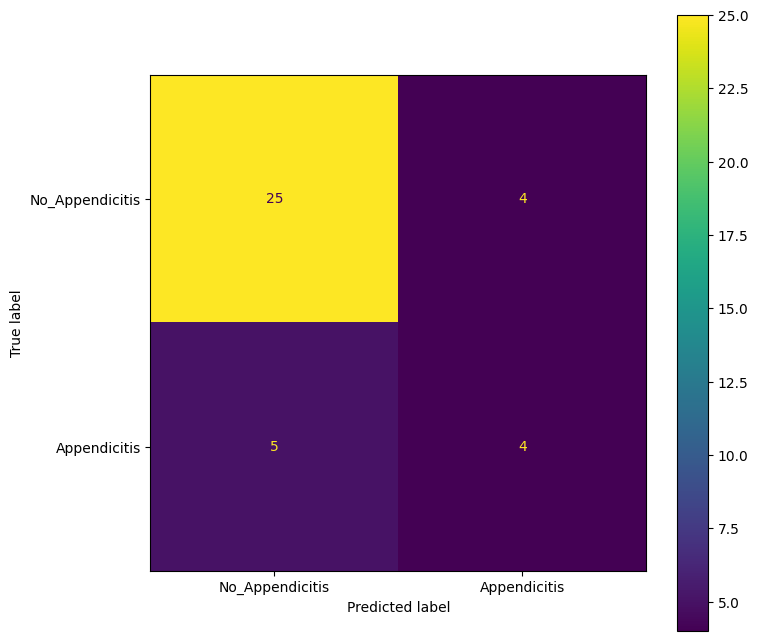

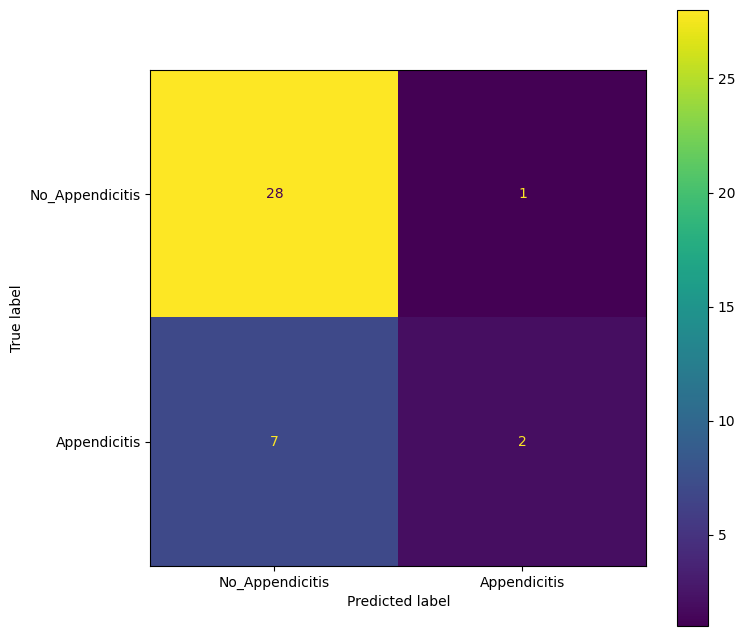

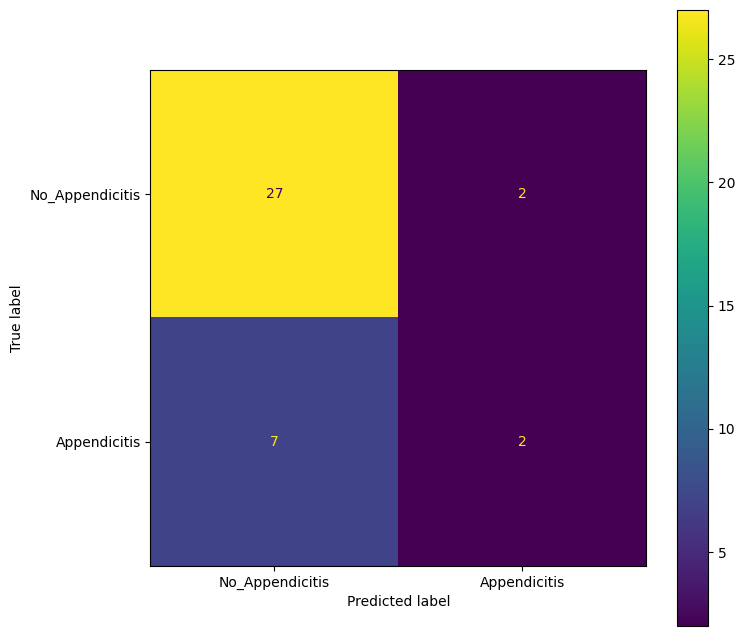

In [61]:
for i in range(0, len(listXQTest)):
    x_test=listXQTest[i]
    lr =list_lrgs[i]
    plt.figure(figsize=(8,8));
    _=ConfusionMatrixDisplay.from_estimator(lr, x_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

Viendo las matrices de confusión. Vemos que a medida que vamos aumentando el numero de niveles en la discretización, perdemos acertividad en los casos de apendicitis. Cosa que no nos interesa debido al peligro que llega tener este hecho (no queremos decirle a un paciente con apendicitis que no lo tiene).

A continuación haremos el algoritmo de K-Vecinos.

In [62]:
list_KNN =[]
param ={'n_neighbors':[1,5,10,20,30,40,50], 
        'weights':['uniform','distance'],
        'leaf_size':[1, 5, 10, 20, 30],
        'metric': ['l2', 'l1', 'cosine']}
for i in range(0, len(listXQTrain)):
    x=listXQTrain[i]
    k_neighbors = KNeighborsClassifier()
    k_neighbors_gr = GridSearchCV(k_neighbors,param,cv=10, n_jobs=-1, refit=True)
    list_KNN.append(k_neighbors_gr)
    k_neighbors_gr.fit(x,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

In [63]:
for i, knn in enumerate(list_KNN):
    print(f"Mejores hiperparametros para Quantile={i+2}")
    show_html(pd.DataFrame(knn.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Mejores hiperparametros para Quantile=2


,params,mean_test_score,rank_test_score
104,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 20, 'weights': 'uniform'}",0.82,1
66,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 40, 'weights': 'uniform'}",0.82,1
64,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 30, 'weights': 'uniform'}",0.82,1
138,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 50, 'weights': 'uniform'}",0.82,1
62,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 20, 'weights': 'uniform'}",0.82,1


Mejores hiperparametros para Quantile=3


,params,mean_test_score,rank_test_score
170,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 5, 'weights': 'uniform'}",0.893,1
16,"{'leaf_size': 1, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.893,1
184,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.893,1
128,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 5, 'weights': 'uniform'}",0.893,1
58,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.893,1


Mejores hiperparametros para Quantile=4


,params,mean_test_score,rank_test_score
209,"{'leaf_size': 30, 'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}",0.89,1
147,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 20, 'weights': 'distance'}",0.89,1
37,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 30, 'weights': 'distance'}",0.89,1
79,"{'leaf_size': 5, 'metric': 'cosine', 'n_neighbors': 30, 'weights': 'distance'}",0.89,1
39,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 40, 'weights': 'distance'}",0.89,1


Vemos que los mejores niveles de discretización son el 3 y 4. Estos presentan un acierto muy cercano al 90%.

In [64]:
list_prediction =[]
for i in range(0, len(listXQTrain)):
    knn = list_KNN[i]
    xtest = listXQTest[i]
    prediction = knn.predict(xtest)
    list_prediction.append(prediction)
    ccuracy_LR = accuracy_score(Y_test, prediction)
    print(f"Acierto de K-Vecino aplicado al conjunto de test y quantile={i+2}:", Accuracy_LR)

Acierto de K-Vecino aplicado al conjunto de test y quantile=2: 0.868421052631579
Acierto de K-Vecino aplicado al conjunto de test y quantile=3: 0.868421052631579
Acierto de K-Vecino aplicado al conjunto de test y quantile=4: 0.868421052631579


Pero podemos ver que todos llegan a tener un acierto similar sobre el conjunto de test. Dando a entender que el modelo donde utilizabamos 2 niveles de discretización no se llego a especializarse en exceso. A diferencia del resto de modelos, que si que lo llegaron a hacer pero no de manera notoria. Ahora veremos el informe de clasificación para ver como esta la acertividad dependiendo del target a predecir.

In [65]:
for i in range(0, len(list_prediction)):
    pred = list_prediction[i]
    print(f"Informe de Clasificación con Quantile={i+2}")
    print(classification_report(pred, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación con Quantile=2
                 precision    recall  f1-score   support

No_Appendicitis       1.00      0.76      0.87        38
   Appendicitis       0.00      0.00      0.00         0

       accuracy                           0.76        38
      macro avg       0.50      0.38      0.43        38
   weighted avg       1.00      0.76      0.87        38

Informe de Clasificación con Quantile=3
                 precision    recall  f1-score   support

No_Appendicitis       0.83      0.86      0.84        28
   Appendicitis       0.56      0.50      0.53        10

       accuracy                           0.76        38
      macro avg       0.69      0.68      0.68        38
   weighted avg       0.76      0.76      0.76        38

Informe de Clasificación con Quantile=4
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.80      0.88        35
   Appendicitis       0.22      0.67      0.33         3

       accuracy  

/home/jeremy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jeremy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jeremy/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Por desgracia,vemos que el modelo con solo 2 niveles de discretización nos da muy buena a puntuación debido al desbalance en el número de muestras que hay en el target. Este modelo solo predice bien los casos de no apendicitis. Por lo tanto, no es un modelo recomendable. 

En cambio, el siguiente modelo con 3 niveles de discretización si que nos llega a proporcionar un nivel de acertividad en los casos positivos de apendicitis. Aun así, este nivel es insuficiente para el proposito de este modelo (únicamente llega a predecir poco más de la mitad de los casos positivos).

Si vemos en cambio el último modelo, llegamos a ver otra vez una caída en la precisión en este caso positivo, pero a cambio aumenta la acertividad en el caso contrario. Este cambio no sale a cuenta para nuestro proposito de uso de estos modelos.

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

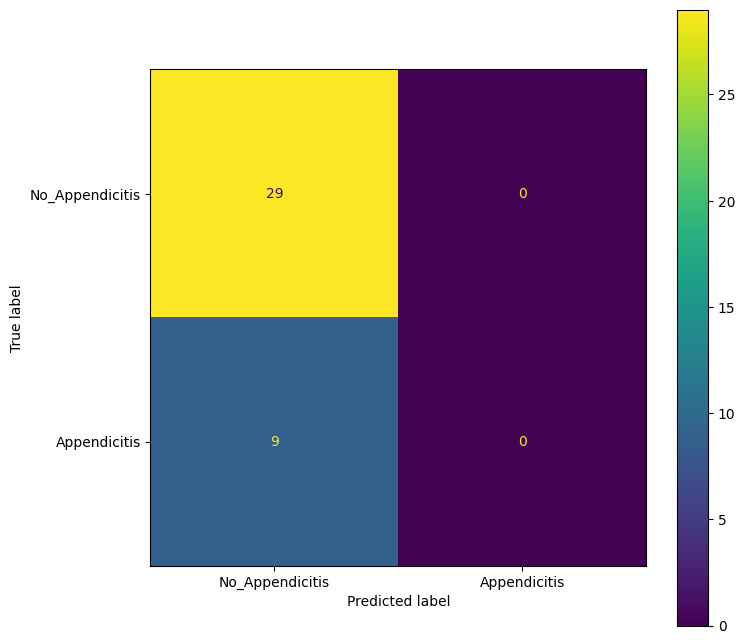

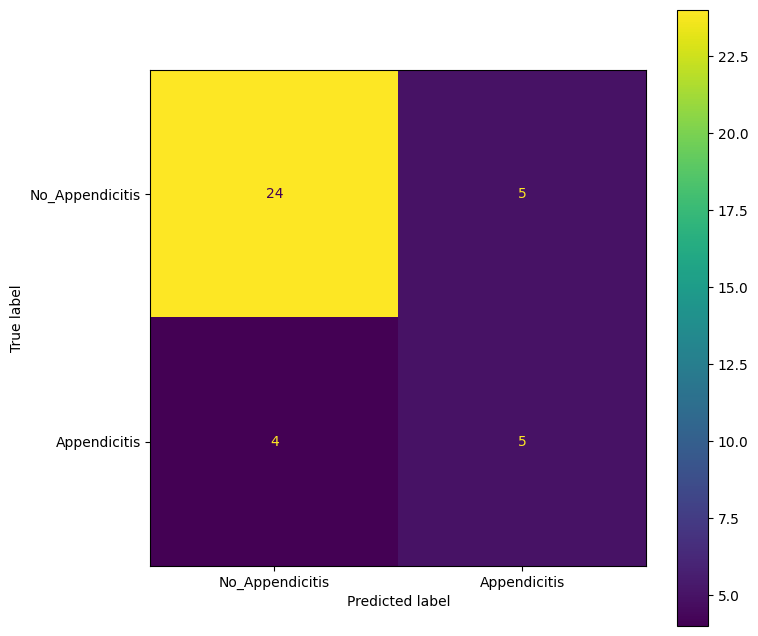

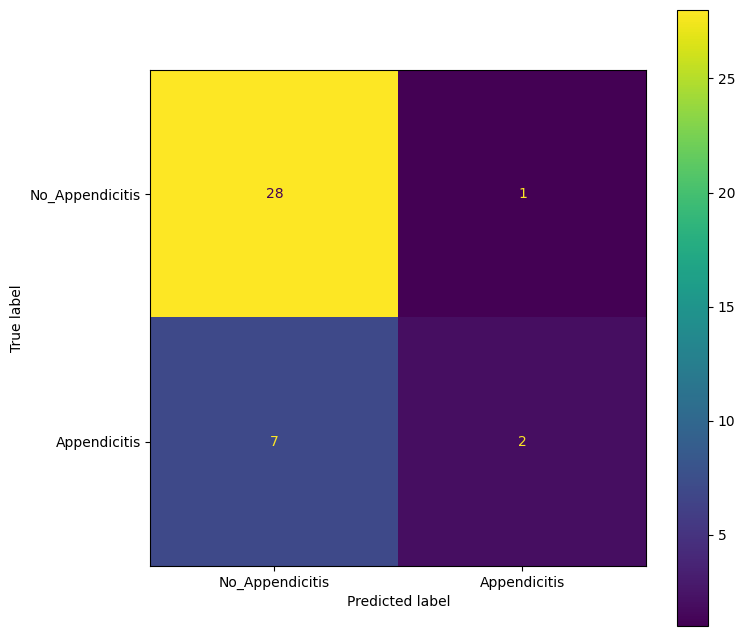

In [66]:
for i in range(0, len(listXQTest)):
    x_test=listXQTest[i]
    knn =list_KNN[i]
    plt.figure(figsize=(8,8));
    _=ConfusionMatrixDisplay.from_estimator(knn, x_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

En conclusión, haciendo este tipo de discretización, yo optaría por utilizar los modelos de Naive Bayes de 2 que nos ofrece un acierto muy similar en los 2 posibles targets. Estos modelo lo que llega a sacrificar es el caso negativo el cual es el que nos interesa que sea "sacrificado" y el caso positivo llega a tener una acertividad cercana al 90%.

A continuación haremos las mismas pruebas pero utilizando los conjuntos de datos que han sido discretizado con la estrategia kmeans.

#### Método KMeans

In [67]:
for i in range(0, len(listXKTrain)):
    x = listXKTrain[i]
    gnb = CategoricalNB()
    r2 = np.mean(cross_val_score(gnb,x,Y_train,cv=10))
    print(f"Acierto medio del conjunto con KMeans={i+2}:",r2)

Acierto medio del conjunto con KMeans=2: 0.85
Acierto medio del conjunto con KMeans=3: 0.8433333333333334
Acierto medio del conjunto con KMeans=4: 0.8800000000000001


A primeras podemos ver que el mejor modelo es el que está tiene una discretización de 4 niveles.

In [68]:
list_prediction =[]
for i in range(0, len(listXKTrain)):
    x = listXKTrain[i]
    xtest = listXKTest[i]
    gnb_model =  CategoricalNB().fit(x,Y_train)
    prediction =gnb_model.predict(xtest)
    list_prediction.append(prediction)
    Accuracy_NB = accuracy_score(Y_test, prediction)
    print(f"Acierto del Naive Bayes aplicado al conjunto de test con KMeans={i+2}:", Accuracy_NB)

Acierto del Naive Bayes aplicado al conjunto de test con KMeans=2: 0.8421052631578947
Acierto del Naive Bayes aplicado al conjunto de test con KMeans=3: 0.8421052631578947
Acierto del Naive Bayes aplicado al conjunto de test con KMeans=4: 0.8157894736842105


En cambio, los mejores modelos son los que han sido discretizado con niveles inferiores. A su vez, podemos ver que no se estan especializados en exceso debido a que que tienen un acierto medio de test muy similar a su acierto con la validación cruzada.

In [69]:
for i in range(0, len(list_prediction)):
    pred = list_prediction[i]
    print(f"Informe de Clasificación con KMeans={i+2}")
    print(classification_report(pred, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación con KMeans=2
                 precision    recall  f1-score   support

No_Appendicitis       0.90      0.90      0.90        29
   Appendicitis       0.67      0.67      0.67         9

       accuracy                           0.84        38
      macro avg       0.78      0.78      0.78        38
   weighted avg       0.84      0.84      0.84        38

Informe de Clasificación con KMeans=3
                 precision    recall  f1-score   support

No_Appendicitis       0.90      0.90      0.90        29
   Appendicitis       0.67      0.67      0.67         9

       accuracy                           0.84        38
      macro avg       0.78      0.78      0.78        38
   weighted avg       0.84      0.84      0.84        38

Informe de Clasificación con KMeans=4
                 precision    recall  f1-score   support

No_Appendicitis       0.86      0.89      0.88        28
   Appendicitis       0.67      0.60      0.63        10

       accuracy        

Podemos ver que el acierto de cada valor del target llega a ser muy similar entre los 3 modelos. Cosa que pasaba de forma similar quando utilizabamos los conjuntos hechos con Quantile. En este caso, destacaríamos que los mejores modelos son los de 2 y 3 niveles de discretización porque predice de mejor manera el caso de apendicitis, aunque este rendimiento no es el óptimo.

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

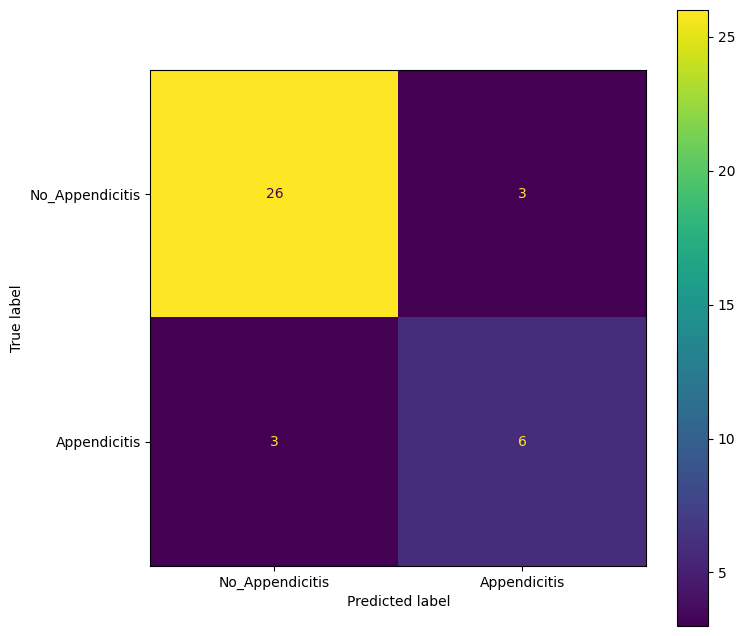

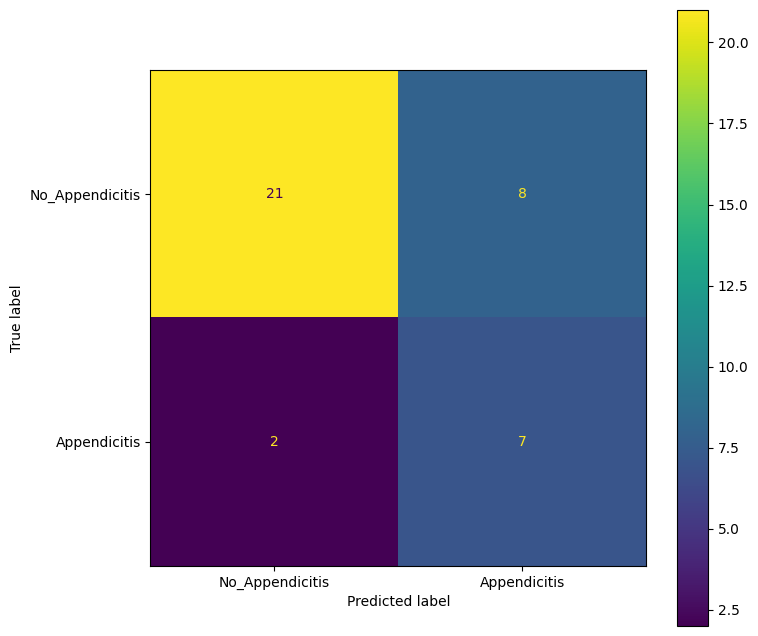

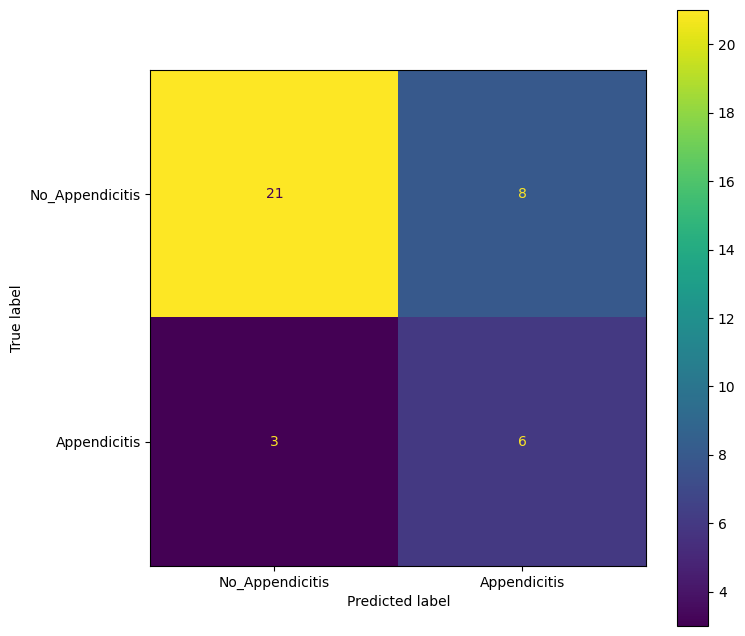

In [70]:
for i in range(0, len(listXKTrain)):
    x = listXKTrain[i]
    xtest = listXKTest[i]
    gnb_model =  GaussianNB().fit(x,Y_train)
    plt.figure(figsize=(8,8));
    _=ConfusionMatrixDisplay.from_estimator(gnb_model, xtest,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

A continuación, haremos la prueba con regresión logística.

In [71]:
list_lrgs =[]
for i in range(0, len(listXKTrain)):
    x = listXKTrain[i]
    lr = LogisticRegression(max_iter=10000, solver="liblinear")
    param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
    lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
    list_lrgs.append(lr_gs)
    lr_gs.fit(x, Y_train)


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

In [72]:
for i, lr in enumerate(list_lrgs):
    print(f"Mejores hiperparametros para KMeans={i+2}")
    show_html(pd.DataFrame(lr.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Mejores hiperparametros para KMeans=2


,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.910,1
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.897,2
41,"{'C': 1000.0, 'penalty': 'l2'}",0.893,3
39,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.893,3
38,"{'C': 501.18723362727246, 'penalty': 'l1'}",0.893,3


Mejores hiperparametros para KMeans=3


,params,mean_test_score,rank_test_score
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.910,1
20,"{'C': 1.0, 'penalty': 'l1'}",0.877,2
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.877,2
21,"{'C': 1.0, 'penalty': 'l2'}",0.860,4
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.857,5


Mejores hiperparametros para KMeans=4


,params,mean_test_score,rank_test_score
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.910,1
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.910,1
21,"{'C': 1.0, 'penalty': 'l2'}",0.893,3
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.890,4
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.877,5


Vemos esta vez que todas las discretizaciones tienen comparten mismo tipo de penalización y el acierto de sus respectivos mejores modelos es el mismo, a diferencia del método quantile que su discretización de 2 niveles era ligeramente inferior.

In [73]:
list_prediction =[]
for i in range(0, len(listXKTrain)):
    lr = list_lrgs[i]
    xtest = listXKTest[i]
    prediction = lr.predict(xtest)
    list_prediction.append(prediction)
    ccuracy_LR = accuracy_score(Y_test, prediction)
    print(f"Acierto de la regresión logística aplicado al conjunto de test y KMeans={i+2}:", Accuracy_LR)

Acierto de la regresión logística aplicado al conjunto de test y KMeans=2: 0.868421052631579
Acierto de la regresión logística aplicado al conjunto de test y KMeans=3: 0.868421052631579
Acierto de la regresión logística aplicado al conjunto de test y KMeans=4: 0.868421052631579


De misma manera que con el método Quantile. Todos los modelos llegan a presentar, los mismos acierto medio. A su vez, a primeras no vemos diferencias con este último método mencionado. 

In [74]:
for i in range(0, len(list_prediction)):
    pred = list_prediction[i]
    print(f"Informe de Clasificación con KMeans={i+2}")
    print(classification_report(pred, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación con KMeans=2
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.82      0.89        34
   Appendicitis       0.33      0.75      0.46         4

       accuracy                           0.82        38
      macro avg       0.65      0.79      0.68        38
   weighted avg       0.90      0.82      0.84        38

Informe de Clasificación con KMeans=3
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.80      0.88        35
   Appendicitis       0.22      0.67      0.33         3

       accuracy                           0.79        38
      macro avg       0.59      0.73      0.60        38
   weighted avg       0.91      0.79      0.83        38

Informe de Clasificación con KMeans=4
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.85      0.90        33
   Appendicitis       0.44      0.80      0.57         5

       accuracy        

En cambio si que podemos ver diferencias con el otro método. Con Quantile, el mejor modelo era utilizando una discretización de 2 niveles. Mientras que en este es mejor con 4. Si sus respectivos aciertos. Con el modelo de Quantile obtenemos 0.86 de acierto en no apendicitis y 0.44 en el suceso contrario. En cambio, con este obtenemos 0.97 y 0.44 respectivamente. Por lo tanto, obtenemos cierta mejora pero aún así insuficiente ya que nuestro proposito es acertar bien los sucesos de apendicitis.

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

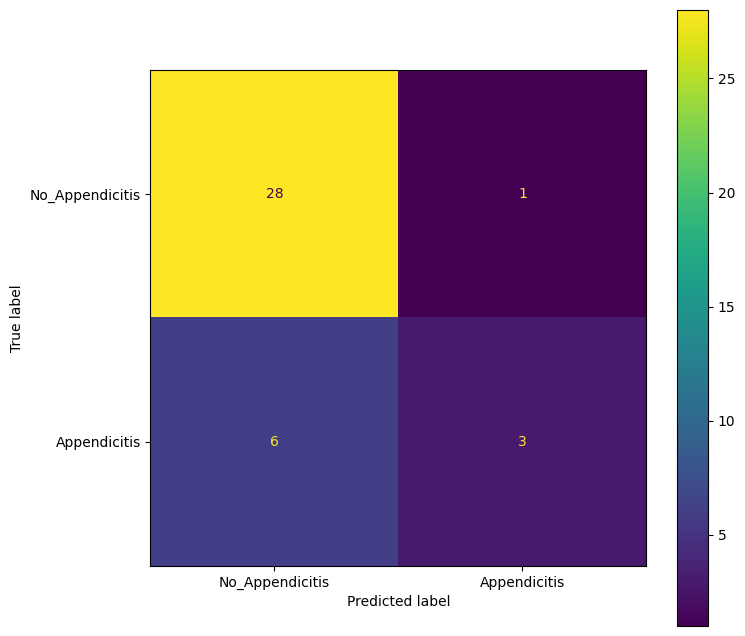

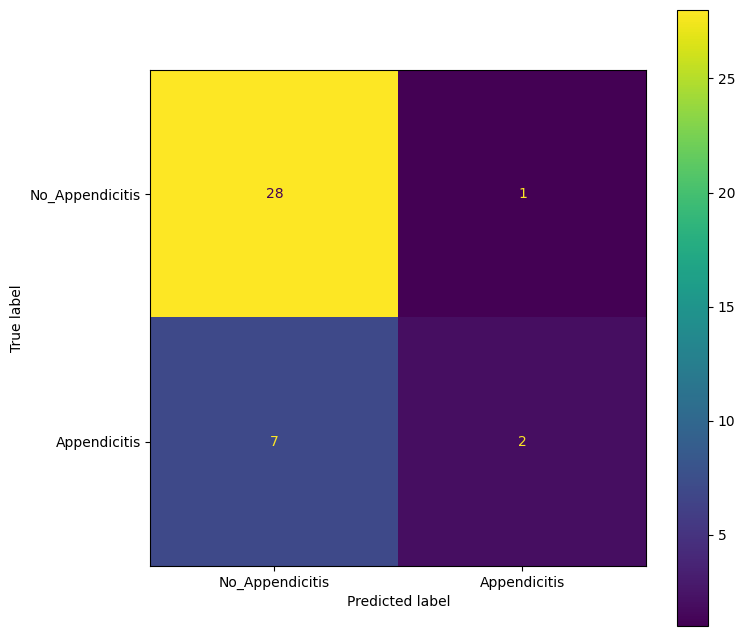

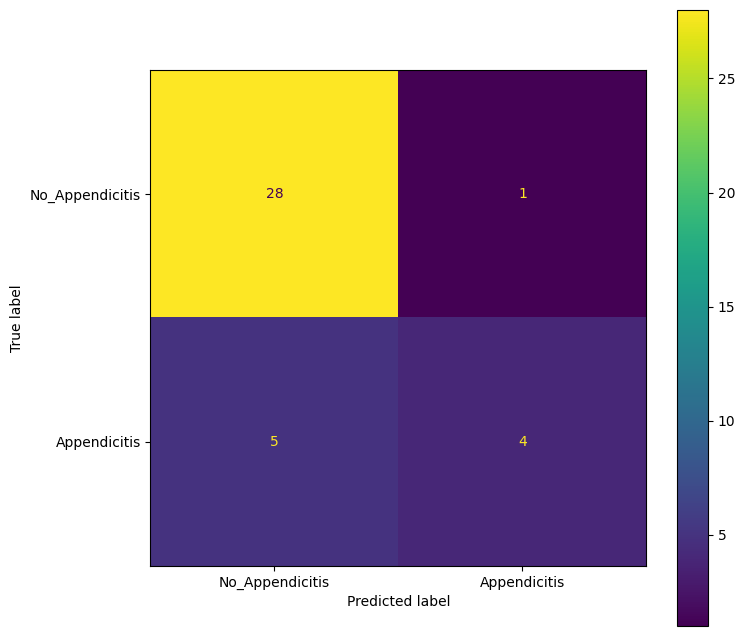

In [75]:
for i in range(0, len(listXQTest)):
    x_test=listXKTest[i]
    lr =list_lrgs[i]
    plt.figure(figsize=(8,8));
    _=ConfusionMatrixDisplay.from_estimator(lr, x_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

Por último, haremos el algoritmo de K-vecinos.

In [76]:
list_KNN =[]
param ={'n_neighbors':[1,5,10,20,30,40,50], 
        'weights':['uniform','distance'],
        'leaf_size':[1, 5, 10, 20, 30],
        'metric': ['l2', 'l1', 'cosine']}
for i in range(0, len(listXKTrain)):
    x=listXKTrain[i]
    k_neighbors = KNeighborsClassifier()
    k_neighbors_gr = GridSearchCV(k_neighbors,param,cv=10, n_jobs=-1, refit=True)
    list_KNN.append(k_neighbors_gr)
    k_neighbors_gr.fit(x,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [1, 5, 10, 20, 30],
                         'metric': ['l2', 'l1', 'cosine'],
                         'n_neighbors': [1, 5, 10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

In [77]:
for i, knn in enumerate(list_KNN):
    print(f"Mejores hiperparametros para KMeans={i+2}")
    show_html(pd.DataFrame(knn.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Mejores hiperparametros para KMeans=2


,params,mean_test_score,rank_test_score
142,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.913,1
2,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 5, 'weights': 'uniform'}",0.913,1
4,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 10, 'weights': 'uniform'}",0.913,1
58,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.913,1
86,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 5, 'weights': 'uniform'}",0.913,1


Mejores hiperparametros para KMeans=3


,params,mean_test_score,rank_test_score
209,"{'leaf_size': 30, 'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}",0.907,1
133,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 20, 'weights': 'distance'}",0.907,1
135,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 30, 'weights': 'distance'}",0.907,1
55,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 50, 'weights': 'distance'}",0.907,1
137,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 40, 'weights': 'distance'}",0.907,1


Mejores hiperparametros para KMeans=4


,params,mean_test_score,rank_test_score
58,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.91,1
30,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 5, 'weights': 'uniform'}",0.91,1
184,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform'}",0.91,1
170,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 5, 'weights': 'uniform'}",0.91,1
156,"{'leaf_size': 20, 'metric': 'cosine', 'n_neighbors': 5, 'weights': 'uniform'}",0.91,1


Principalmente podemos destacar su acierto, el cual es más alto que sus respectivos modelos de Quantile.

In [78]:
list_prediction =[]
for i in range(0, len(listXKTrain)):
    knn = list_KNN[i]
    xtest = listXKTest[i]
    prediction = knn.predict(xtest)
    list_prediction.append(prediction)
    ccuracy_LR = accuracy_score(Y_test, prediction)
    print(f"Acierto de K-Vecino aplicado al conjunto de test y KMeans={i+2}:", Accuracy_LR)

Acierto de K-Vecino aplicado al conjunto de test y KMeans=2: 0.868421052631579
Acierto de K-Vecino aplicado al conjunto de test y KMeans=3: 0.868421052631579
Acierto de K-Vecino aplicado al conjunto de test y KMeans=4: 0.868421052631579


En cambio, en este caso, no vemos mejora significativa ni con la regresión logística ni con K-Vecino hecho con el método Quantile (ambos modelos han obtenido el mismo acierto sobre el conjunto de test).

In [79]:
for i in range(0, len(list_prediction)):
    pred = list_prediction[i]
    print(f"Informe de Clasificación con Quantile={i+2}")
    print(classification_report(pred, Y_test,target_names=["No_Appendicitis", "Appendicitis"]))

Informe de Clasificación con Quantile=2
                 precision    recall  f1-score   support

No_Appendicitis       0.93      0.87      0.90        31
   Appendicitis       0.56      0.71      0.63         7

       accuracy                           0.84        38
      macro avg       0.74      0.79      0.76        38
   weighted avg       0.86      0.84      0.85        38

Informe de Clasificación con Quantile=3
                 precision    recall  f1-score   support

No_Appendicitis       0.93      0.79      0.86        34
   Appendicitis       0.22      0.50      0.31         4

       accuracy                           0.76        38
      macro avg       0.58      0.65      0.58        38
   weighted avg       0.86      0.76      0.80        38

Informe de Clasificación con Quantile=4
                 precision    recall  f1-score   support

No_Appendicitis       0.97      0.90      0.93        31
   Appendicitis       0.67      0.86      0.75         7

       accuracy  

En este caso si que vemos diferencias con el método Quantile. En este caso, todos los modelos llegan a tener acierto en el caso positivo de apendicitis. A su vez, el mejor modelo llega a tener un acierto de apendicitis del 0.67, superando por 11 centésimas al mejor modelo de Quantile. A su vez, supera por 23 centésimas al mejor modelo de regresión logística del método KMeans. 

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

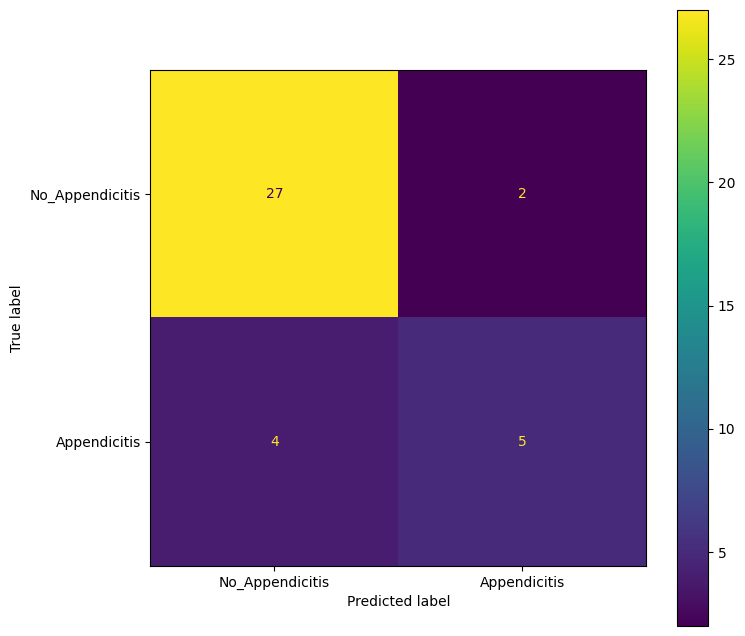

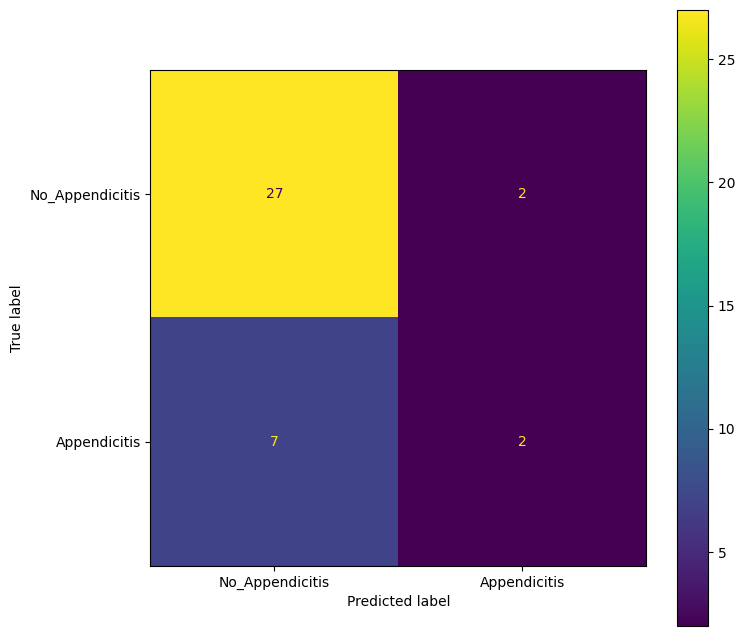

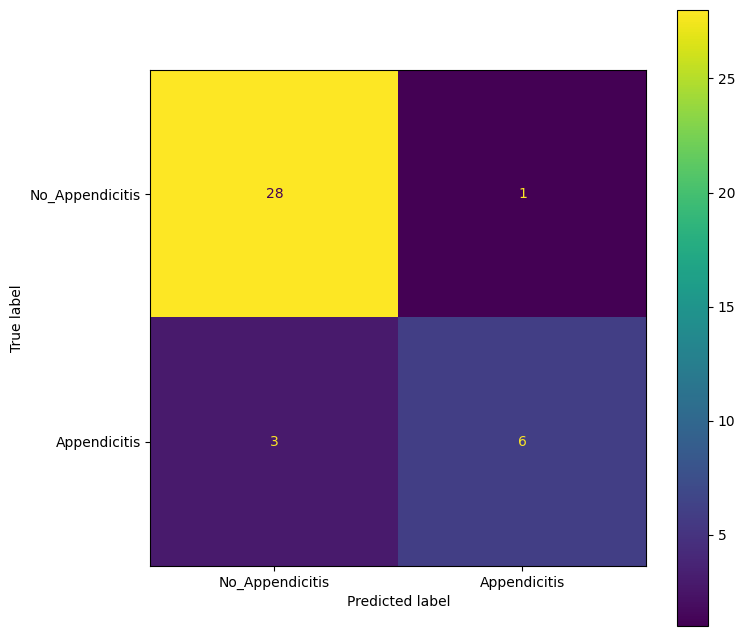

In [80]:
for i in range(0, len(listXKTest)):
    x_test=listXKTest[i]
    knn =list_KNN[i]
    plt.figure(figsize=(8,8));
    _=ConfusionMatrixDisplay.from_estimator(knn, x_test,Y_test, display_labels=["No_Appendicitis", "Appendicitis"], ax=plt.subplot());

En general podemos destacar que entre todos los modelos el mejor ha sido Naive Bayes utilizando el 2 niveles de discretización y utilizando el método Quantile. Todo esto debido principalmente a su alta tasa de acierto con el caso positivo de apendicitis. El caso contrario en cambio ofrecía tasas bajas de acierto pero aún así eran suficientes para el proposito del modelo (tasa de acierto cercana al 80%). 

También hemos podido que a medida que utilizabamos modelos más complejos vemos que cada vez aumenta el acierto del caso de no tener apendicitis, pero baja considerablemente el contrario. Esto puede ser por la muestra tan pequeña que llegamos a tener y el desbalance que tenemos de tipos. Al tener muchas más instancias de caso donde no hay apendicitis que los que si, los modelos si que pueden llegar a aprender de manera más precisa este caso. Para comprobar esto, tendríamos que tener una muestra más grande y tener más casos positivos.

Ahora contestaremos las preguntas del apartado c:

*¿ha afectado este proceso a la calidad de los modelos?*

Si que ha llegado a afectar debido a que hemos podido mejor el caso que tenia una precisión/acierto más bajo (caso positivo).

*¿Cuál elegirías y por qué?*

Como he dicho anteriormente, debido a que nosotros queremos máximizar la calidad de las predicciones positivas frente a las negativas. El modelo que yo eligiría sería Naive Bayes con discretización de 2 niveles y método Quantile. Este nos llega a dar una precisión superior en el caso positivo.

Por último vamos a responder la última pregunta del problema.
*Teniendo en cuenta la interpretabilidad de los modelos, ¿crees que tiene ventajas el trabajar con datos discretizados? ¿Por qué?*

Si que llega a tener ventajas, debido a que ayudamos al modelo a hacer separaciones claras entre los targets. En el caso de naive Bayes, se llegan hacer separaciones del espacio. Si asumimos espacio que trabajen con datos continuos, esta frontera de regiones puede llegar a ser difícil de calcular debido tanto a problemas físicos (la precisión de la coma flotante o el propio int); como que también los datos pueden llegar a tener más variabilidad de valores y no podrá llegar a ver que zona de esa dimension es la que induce a un valor o un otro. Pero si trabajamos con datos discretos, puede llegar haber más instancias con el mismo valor y a su vez no habrá tantos problemas de precisión, haciendo que estas fronteras se puedan calcular mejor.